In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import numpy as np
import torch
dev = torch.device("cuda")
import torch.optim as optim
root_dir = '/mnt/home/spandey/ceph/ltu-cmass/cmass/bias/charm/'
os.chdir(root_dir)
import sys, os
sys.path.append(root_dir)
from combined_models import COMBINED_Model
from all_models import *
from utils_data_prep_cosmo import *
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
from tqdm import tqdm
    
import yaml
import pickle as pk
# autoreload modules
%load_ext autoreload
%autoreload 2

import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl




In [2]:
run_config_name = 'LONGTRAIN_cond_fastpm_ns128_run_Ntot_M1_Mdiff_subselrand.yaml'
with open("configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)






In [3]:
# !pip install --upgrade numpy



In [4]:
config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
nsubvol_per_ji = int(config_sims['nsubvol_per_ji'])
nsubvol_fid = int(config_sims['nsubvol_fid'])
subsel_criteria = config_sims['subsel_criteria']
num_cosmo_params = int(config_sims['num_cosmo_params'])
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
z_inference = config_sims['z_inference']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
# subsel_highM1 = config_sims['subsel_highM1']
# nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
K_M1 = config_net['K_M1']
B_M1 = config_net['B_M1']
nflows_M1_NSF = config_net['nflows_M1_NSF']

K_Mdiff = config_net['K_Mdiff']
B_Mdiff = config_net['B_Mdiff']
nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']

base_dist_Ntot = config_net['base_dist_Ntot']
if base_dist_Ntot == 'None':
    base_dist_Ntot = None
base_dist_M1 = config_net['base_dist_M1']
base_dist_Mdiff = config_net['base_dist_Mdiff']
ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    ninp = len(z_all_FP)
elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp + num_cosmo_params




In [5]:
lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])




/tmp/ipykernel_510457/3635687768.py:11: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  int_val = sp.integrate.simps(hmf, lgM_rescaled)
/tmp/ipykernel_510457/3635687768.py:16: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


In [6]:
with open("/mnt/home/spandey/ceph/AR_NPE/run_configs/vary_cosmo/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)

config_train = config['train_settings']
batch_size = config_train['batch_size_DL']
all_gpu = config_train['all_gpu']

try:
    L2norm_Ntothist = config_train['L2norm_Ntothist']
except:
    L2norm_Ntothist = False

try:
    L2norm_M1hist = config_train['L2norm_M1hist']
except:
    L2norm_M1hist = False

nflows_train = config_train['nflows_train']

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/CLIPPED_FINALTEST_SUBSEL_Ntot_M1_Mdiff_plexp_ns_' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim  \
#                             + '_nc' + str(nc) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist) + '_TRY2'

save_string = config_train['save_string']

save_bestfit_model_dir = '/mnt/home/spandey/ceph/ltu-cmass/cmass/bias/charm/trained_models/' + \
                            'HRES_SUMGAUSS_subsel_random_LONGTRAIN_Ntot_only_plexp_ns_' + \
                            str(len(ji_array)) + \
                            '_cond_sim_' + cond_sim  + '_ns_' + str(ns_h) \
                            + '_nc' + str(nc) + '_mass_' + mass_type + \
                            '_KM1_' + str(K_M1) + \
                            '_stype_' + stype + \
                             '_Nmax' + str(Nmax) + save_string

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/ltu-cmass/cmass/bias/charm/trained_models/'


print(save_bestfit_model_dir, os.path.exists(save_bestfit_model_dir))
# make directory if it doesn't exist
import os
if not os.path.exists(save_bestfit_model_dir):
    os.makedirs(save_bestfit_model_dir)


nepochs_Ntot_only = config_train['nepochs_Ntot_only']
nepochs_Ntot_M1_only = config_train['nepochs_Ntot_M1_only']
nepochs_all = config_train['nepochs_all']




/mnt/home/spandey/ceph/ltu-cmass/cmass/bias/charm/trained_models/HRES_SUMGAUSS_subsel_random_LONGTRAIN_Ntot_only_plexp_ns_1024_cond_sim_fastpm_ns_128_nc4_mass_rockstar_200c_KM1_8_stype_cic_Nmax8_COND_FPM_Mmin1e13_nsubvolji8_nsubvolfid512_nsubselrand True


In [7]:
sigv = 0.05
mu_all = np.arange(Nmax + 1) + 1
sig_all = sigv * np.ones_like(mu_all)
ngauss_Nhalo = Nmax + 1


In [8]:
Nmax


8

In [9]:
num_cond_Ntot = num_cond

model_BinaryMask = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=2,
    mu_all=mu_all[:2],
    sig_all=sig_all[:2],
    base_dist=base_dist_Ntot   
    )

model_BinaryMask.to(dev)


model_multiclass = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=ngauss_Nhalo - 1,
    mu_all=mu_all[1:] - 1,
    sig_all=sig_all[1:],
    base_dist=base_dist_Ntot   
    )


model_multiclass.to(dev)


num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

model_M1 = NSF_M1_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_M1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_pdf,
    hmf_cdf_tointerp=hmf_cdf    
    )

ndim_diff = Nmax
num_cond_Mdiff = num_cond + 2
model_Mdiff = NSF_Mdiff_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Mdiff,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )

# model_Mdiff = None
# model_M1 = None

ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_BinaryMask,
    model_multiclass,
    ndim,
    ksize,
    ns_d,
    ns_h,
    # nb,
    1,    
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Binary_cond=True,
    sep_MultiClass_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    num_cond_Binary = num_cond_Ntot,
    num_cond_MultiClass = num_cond_Ntot,
    num_cond_M1 = num_cond_M1,
    num_cond_Mdiff = num_cond_Mdiff
    )

model.to(dev)
# print()


optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_all_it = []
loss_min = 1e20
epoch_tot_counter = 0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=1000, verbose=True, cooldown=1000, min_lr=1e-5)



In [10]:
jf = 0
save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)

print('loading bestfit model')
bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])
scheduler.load_state_dict(bestfit_model['scheduler'])
loss_min = bestfit_model['loss_min']
loss = bestfit_model['loss']
# lr = bestfit_model['lr']
epoch_tot_counter = bestfit_model['epoch_tot_counter']
# for g in optimizer.param_groups:
#     g['lr'] = lr
    # g['lr'] = 0.0005

print(loss_min, epoch_tot_counter)








loading bestfit model
-6.543231010437012 33032


In [11]:
# test_LH_id = 1000
test_LH_id = 3
# test_LH_id = 10


In [12]:
n_dim_red = (nf - 1) // 2
n_pad = n_dim_red * nc

df_zg = pk.load(open('/mnt/ceph/users/spandey/Quijote/data_NGP_self_fastpm_LH/%d/density_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk'%test_LH_id,'rb'))
df_test_zg = df_zg['density_cic_unpad_combined']
df_test_pad_zg = np.pad(df_test_zg, n_pad, 'wrap')

df_zIC = pk.load(open('/mnt/ceph/users/spandey/Quijote/data_NGP_self_fastpm_LH/%d/density_HR_full_m_res_128_z=99_nbatch_8_nfilter_3_ncnn_0.pk'%test_LH_id,'rb'))
df_test_zIC = df_zIC['density_cic_unpad_combined']
df_test_pad_zIC = np.pad(df_test_zIC, n_pad, 'wrap')

z_REDSHIFT_diff_sig_VALUE = z_all_FP[-1]
VALUE_SIG = float(z_REDSHIFT_diff_sig_VALUE.split('_')[4])
density_smoothed = gaussian_filter(df_test_pad_zg, sigma=VALUE_SIG)
df_test_pad_constrast_zg = density_smoothed - df_test_pad_zg

df_test_all_pad = np.stack([np.log(1 + df_test_pad_zg + 1e-10), np.log(1 + df_test_pad_zIC+ 1e-10), df_test_pad_constrast_zg], axis=0)[None,None,:]


In [13]:
density_smoothed = gaussian_filter(df_test_zg, sigma=VALUE_SIG)
df_test_constrast_zg = density_smoothed - df_test_zg

df_test_all_unpad = np.stack([np.log(1 + df_test_zg + 1e-10), np.log(1 + df_test_zIC + 1e-10), df_test_constrast_zg], axis=0)[None,None,:]


In [14]:
cond_nsh_test = np.moveaxis(df_test_all_unpad, 2, 5)
nsims_test = cond_nsh_test.shape[1]
nax_h_test = cond_nsh_test.shape[2]
ninp_test = cond_nsh_test.shape[-1]
cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h_test ** 3), ninp_test))).cuda(dev)    




In [15]:
LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'
LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)
# cosmo_val_test = np.tile(LH_cosmo_val_all[test_LH_id], (*df_test_all_unpad.shape ,1))[0,...][None,:]
cosmo_val_test = np.tile(LH_cosmo_val_all[test_LH_id], (cond_tensor_nsh_test.shape[1] ,1))[None,:]


In [16]:
# df_test_all_pad.shape, df_test_all_unpad.shape, cosmo_val_test.shape
df_test_all_pad = torch.tensor(df_test_all_pad).to(dev)
df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(dev)
cosmo_val_test = torch.tensor(cosmo_val_test, dtype=torch.float32).to(dev)



/tmp/ipykernel_510457/3861550565.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(dev)


In [17]:
# print(df_test_all_pad.shape)

df_test_all_pad.shape, df_test_all_unpad.shape, cosmo_val_test.shape

(torch.Size([1, 1, 3, 136, 136, 136]),
 torch.Size([1, 2097152, 3]),
 torch.Size([1, 2097152, 5]))

In [18]:
train_Ntot, train_M1, train_Mdiff = 1, 1, 1
train_binary, train_multi = 1, 1
Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, cond_inp_M1_test = model.inverse(
    cond_x=df_test_all_pad,
    cond_x_nsh=df_test_all_unpad,
    cond_cosmo=cosmo_val_test,
    use_truth_Nhalo=1-train_Ntot,
        use_truth_M1=1-train_M1,
        use_truth_Mdiff=1-train_Mdiff, 
    mask_Mdiff_truth=None,
    mask_M1_truth=None,
    Nhalos_truth=None,
    M1_truth=None,
    Mdiff_truth=None,
    train_binary=train_binary,
    train_multi=train_multi,   
    train_M1=train_M1,
    train_Mdiff=train_Mdiff,
    )

Ntot_samp_test = Ntot_samp_test[0][:,np.newaxis]
save_subvol_Nhalo = Ntot_samp_test.reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test)
save_subvol_M1 = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:,0]
                    ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, 1)
save_subvol_Mdiff = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                        ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)

                        

/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/torch/nn/modules/conv.py:605: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv3d(


In [19]:
mask_subvol_Mtot1 = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test)[...,None]
mask_subvol_Mtot2 = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)
mask_subvol_Mtot = np.concatenate([mask_subvol_Mtot1, mask_subvol_Mtot2], axis=-1)




In [20]:
# mask_subvol_Mtot1.shape, mask_subvol_Mtot2.shape
import gc
# model.cpu()
# del model
gc.collect()
torch.cuda.empty_cache()


In [21]:
# Ntot_samp_test.shape
import torch
torch.cuda.empty_cache()


In [22]:
ns_h


128

In [23]:
save_subvol_Mtot = np.zeros((nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff + 1))
# Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
for jd in range(ndim_diff + 1):
    if jd == 0:
        save_subvol_Mtot[..., jd] = (save_subvol_M1[..., 0] + 0.5) * (lgMmax - lgMmin) + lgMmin
    else:
        save_subvol_Mtot[...,
                        jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (lgMmax - lgMmin)


save_subvol_Mtot *= mask_subvol_Mtot



In [24]:
save_subvol_Mtot.shape, save_subvol_Nhalo.shape


((1, 128, 128, 128, 9), (1, 128, 128, 128))

In [25]:
Nhalos = save_subvol_Nhalo[0,...]
M_halos = save_subvol_Mtot[0,...]
            
# create the meshgrid
zv = 0.0
av = 1. / (1 + zv)
xall = (np.linspace(0, 1000, ns_h + 1))
xarray = av * 0.5 * (xall[1:] + xall[:-1])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')


x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
# Nmax_sel = 3
k = 0
for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
                Nh_vox = int(Nhalos[jx, jy, jz])
                if Nh_vox > 0:
                    # if Nh_vox > Nmax_sel:
                    #     Nh_vox = Nmax_sel

                    x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                    y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                    z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                    
                    lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                    k += Nh_vox

# convert to numpy arrays
x_h_mock = np.concatenate(x_h_mock)
y_h_mock = np.concatenate(y_h_mock)
z_h_mock = np.concatenate(z_h_mock)
pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
lgMass_mock = np.concatenate(lgM_mock)
# convert to float data type
pos_h_mock = pos_h_mock.astype('float32')
lgMass_mock = lgMass_mock.astype('float32')



In [201]:
saved = {'pos_h_mock': pos_h_mock, 'lgMass_mock': lgMass_mock}
pk.dump(saved, open('/mnt/home/spandey/ceph/ltu-cmass/cmass/bias/charm/testing_notebook' + '/pos_lgM_mock_LH_%d.pk'%test_LH_id, 'wb'))



In [29]:
sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH'
fname = sdir + '/' + str(test_LH_id) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.5.pk'
# else:
#     fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
df_h_full = pk.load(open(fname, 'rb'))
df_Mh_all_truth_comb, df_Nh_truth_comb = df_h_full['M_halos_combined'], df_h_full['N_halos_combined']
df_Nh_truth_comb = np.clip(df_Nh_truth_comb, 0, Nmax)




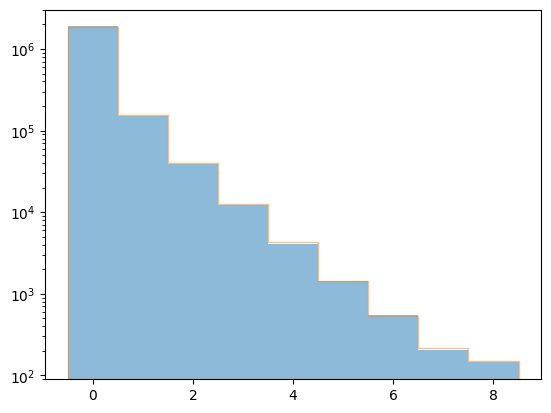

In [30]:
# df_Nh_truth_comb.shape, df_Mh_all_truth_comb.shape, pos_h_mock.shape, lgMass_mock.shape
bin_cents = np.array(np.arange(Nmax + 1))
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
bin_edges = np.insert(bin_edges,0, -0.5)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)


pl.figure()
_ = pl.hist(df_Nh_truth_comb.flatten(), bins=bin_edges, alpha=0.5, label='truth')
_ = pl.hist(Nhalos.flatten(), bins=bin_edges, alpha=0.5, label='inferred', histtype='step')
pl.yscale('log')




In [31]:
ptypes       = [1]
grids         = [128]
BoxSize = 1000.0 #Mpc/h ; size of box
# snap_num_array = [4, 3]
snapnum = 3
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
snapdir = snap_dir_base + '/' + str(test_LH_id)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth_orig = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth_orig = rockstar[:,index_M]  #Halo masses in Msun/h
lgmass_truth_orig = np.log10(mass_truth_orig)

vel_h_truth_orig = rockstar[:,header.index('VX'):header.index('VZ')+1]


In [32]:
import Pk_library as PKL
import MAS_library as MASL

sub_SN = False
# sub_SN = True

saved_all_jsim = {}
x_h_truth, y_h_truth, z_h_truth, lgM_truth = [], [], [], []
for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
                # Nh_vox = int(Nhalos_truth_recomb[jx, jy, jz])
                Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])                    
                if Nh_vox > 0:
                    # if Nh_vox > Nmax_sel:
                    #     Nh_vox = Nmax_sel

                    x_h_truth.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                    y_h_truth.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                    z_h_truth.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                    
                    # lgM_truth.append((M_halos_truth_recomb[jx, jy, jz, :Nh_vox]))
                    lgM_truth.append((df_Mh_all_truth_comb[jx, jy, jz, :Nh_vox]))

# convert to numpy arrays
x_h_truth = np.concatenate(x_h_truth)
y_h_truth = np.concatenate(y_h_truth)
z_h_truth = np.concatenate(z_h_truth)
pos_h_truth = np.vstack((x_h_truth, y_h_truth, z_h_truth)).T
lgMass_truth = np.concatenate(lgM_truth)
# convert to float data type
pos_h_truth = pos_h_truth.astype('float32')
lgMass_truth = lgMass_truth.astype('float32')

grid    = ns_h    #the 3D field will have grid x grid x grid voxels
BoxSize = 1000.0 #Mpc/h ; size of box
MAS     = 'NGP'  #mass-assigment scheme
verbose = False   #print information on progress

Mmin_Pk_all = np.array([13.0, 13.0, 13.5, 14.0, 14.5])
Mmax_Pk_all = np.array([16.0, 13.5, 14.0, 14.5, 15.0])
# Mmin_Pk_all = np.log10(np.array([1e13, 5e13, 7e13, 1e14, 5e14]))
# Mmax_Pk_all = np.log10(np.array([1e17, 7e13, 1e14, 5e14, 1e15]))  
# Mmin_Pk_all[0] = 13.0
# MAS_all = [['NGP',None], 
# ['NGP','NGP'], ['CIC', None], ['CIC','CIC']]
# Mmin_Pk_all = -1.0
# Mmax_Pk_all = 100.0

saved_Pk_Bk = {}

for j in range(len(Mmin_Pk_all)):
    saved_j = {}
    # Mmin_Pk, Mmax_Pk = Mmin_Pk_all, Mmax_Pk_all
    Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]
    indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
    print(Mmin_Pk, Mmax_Pk, ', number in truth:,', len(indsel_Pk_truth))
    shot_noise_truth2 = BoxSize**3/len(indsel_Pk_truth)
    mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
    pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
    MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
    mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float32);  mesh_truth2 -= 1.0
    Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)

    if sub_SN:
        saved_j['Pk_truth_vox'] = Pk_truth2.Pk[:,0] - shot_noise_truth2
    else:
        saved_j['Pk_truth_vox'] = Pk_truth2.Pk[:,0]


    Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]
    indsel_Pk_truth = np.where((lgmass_truth_orig > Mmin_Pk) & (lgmass_truth_orig < Mmax_Pk))[0]
    print(Mmin_Pk, Mmax_Pk, ', number in truth:,', len(indsel_Pk_truth))
    shot_noise_truth = BoxSize**3/len(indsel_Pk_truth)
    mesh_truth = np.zeros((grid, grid, grid), dtype=np.float32)
    pos_truth = (pos_h_truth_orig[indsel_Pk_truth,...]).astype(np.float32)
    MASL.MA(pos_truth, mesh_truth, BoxSize, MAS)
    mesh_truth /= np.mean(mesh_truth, dtype=np.float32);  mesh_truth -= 1.0
    Pk_truth = PKL.Pk(mesh_truth, BoxSize, axis=0, MAS=None, threads=1)

    if sub_SN:
        saved_j['Pk_truth_orig'] = Pk_truth.Pk[:,0] - shot_noise_truth
    else:
        saved_j['Pk_truth_orig'] = Pk_truth.Pk[:,0]

    # print('Pk_truth_orig', Pk_truth.Pk[:,0])
    # print('Pk_truth_vox', Pk_truth2.Pk[:,0])


    indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
    print(Mmin_Pk, Mmax_Pk, ' number in mock:,', len(indsel_Pk_mock))        
    mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
    pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
    MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
    mesh_mock /= np.mean(mesh_mock, dtype=np.float32);  mesh_mock -= 1.0
    Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)  

    shot_noise_mock = BoxSize**3/len(indsel_Pk_mock)  

    Pk_mockxtruth2 = PKL.XPk([mesh_truth2,mesh_mock], BoxSize, axis=0, MAS=[None, None], threads=1)

    if sub_SN:
        saved_j['Pk_mock'] = Pk_mock.Pk[:,0] - shot_noise_mock
    else:
        saved_j['Pk_mock'] = Pk_mock.Pk[:,0]

    saved_j['Pk_mockxtruth'] = Pk_mockxtruth2.XPk[:,0,0]
    saved_j['k_Pk'] = Pk_mockxtruth2.k3D
    

    saved_Pk_Bk[j] = saved_j

saved_all_jsim['Pk_Bk'] = saved_Pk_Bk



13.0 16.0 , number in truth:, 295378

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds
13.0 16.0 , number in truth:, 295475

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds
13.0 16.0  number in mock:, 301494

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.09 seconds

Computing power spectra of the fields...
Time FFTS = 0.03
Time loop = 0.05
Time taken = 0.09 seconds
13.0 13.5 , number in truth:, 223160

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds
13.0 13.5 , number in truth:, 223251

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds
13.0 13.5  number in mock:, 225818

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds

Computing power spectra of the fields...
Time FFTS = 0.03
Time loop = 0.06
Time taken = 0.09 seco

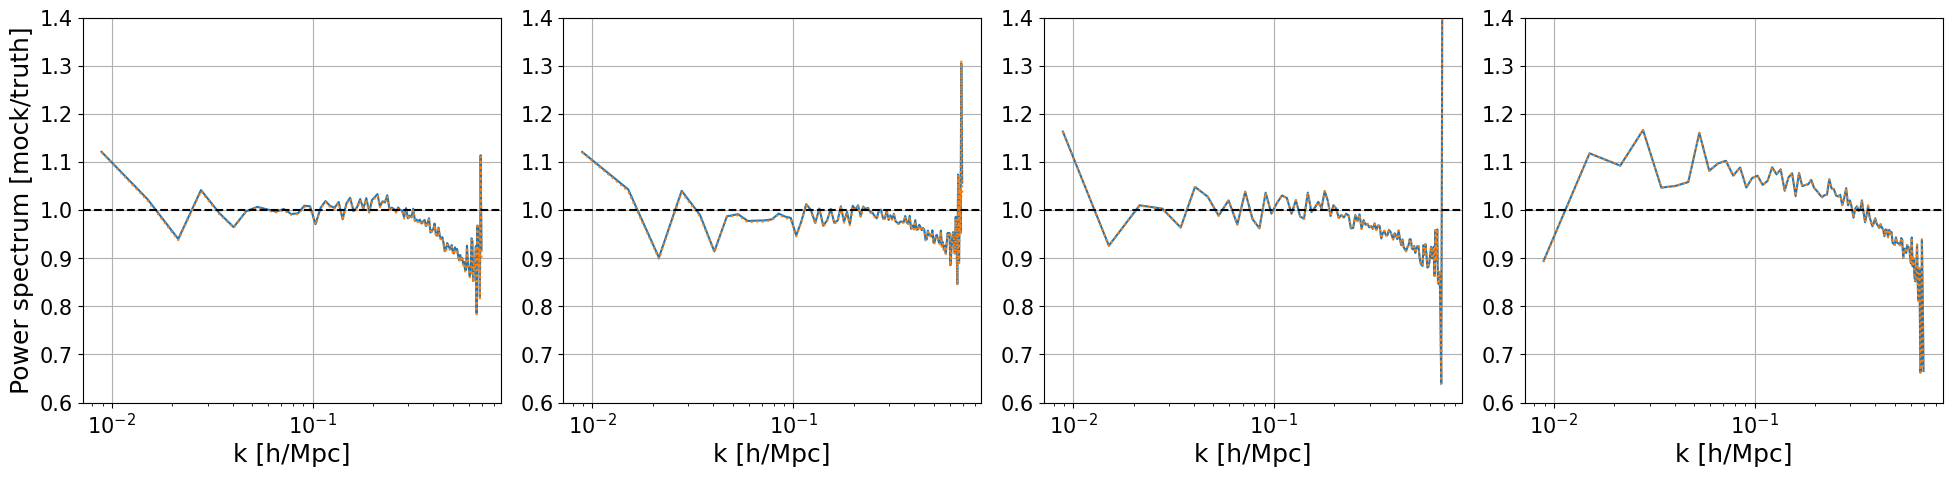

In [33]:
fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=False, sharex=True, gridspec_kw={'wspace': 0.15, 'hspace': 0})
for idim in range(4):
    # M_idim_truth = df_Mh_all_truth[..., idim]
    # hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
    if idim == 0:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock']/saved_all_jsim['Pk_Bk'][0]['Pk_truth_vox'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock']/saved_all_jsim['Pk_Bk'][0]['Pk_truth_orig'], ls=':')        
    if idim == 1:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mock']/saved_all_jsim['Pk_Bk'][1]['Pk_truth_vox'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mock']/saved_all_jsim['Pk_Bk'][1]['Pk_truth_orig'], ls=':')                
    if idim == 2:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mock']/saved_all_jsim['Pk_Bk'][2]['Pk_truth_vox'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mock']/saved_all_jsim['Pk_Bk'][2]['Pk_truth_orig'], ls=':')                
    if idim == 3:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mock']/saved_all_jsim['Pk_Bk'][3]['Pk_truth_vox'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mock']/saved_all_jsim['Pk_Bk'][3]['Pk_truth_orig'], ls=':')                
    # ax[idim].set_yscale('log')
    ax[idim].set_xscale('log')  
    # ax[idim].grid()  
    ax[idim].tick_params(axis='both', which='major', labelsize=15)
    ax[idim].tick_params(axis='both', which='minor', labelsize=15)
    ax[idim].set_xlabel('k [h/Mpc]', size=18)
    
    if idim == 0:
        ax[idim].set_ylabel('Power spectrum [mock/truth]', size=18)

    ax[idim].axhline(1.0, ls='--', color='k')
    ax[idim].set_ylim(0.6, 1.4)
    ax[idim].grid()


    



In [56]:
# LH_cosmo_val_all[test_LH_id]
from halotools.sim_manager import UserSuppliedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory

from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.halo import mass_so

p_hod = {
        'logMmin': 13.03, 
        'sigma_logM':0.38,
        'logM0': 13.27, 
        # 'logM1': 14.08, 
        # 'logM1': 15.08,     
        'logM1': 30.08,         
        'alpha': 0.76
        }

def get_HOD_mock(pos_halos, mass_halos, R200c_halos, conc_halos, Lbox=BoxSize, redshift=0.5, particle_mass=1e9, p_hod=p_hod):
    """
    Function to get the HOD of the mock halos
    """

    num_halos = len(pos_halos)
    ids = np.arange(0, num_halos)
    halo_upid = -1 * np.ones(num_halos)
    # Create a UserSuppliedHaloCatalog object
    halocat = UserSuppliedHaloCatalog(redshift=redshift, Lbox=Lbox, particle_mass=particle_mass, 
                                      halo_x=pos_halos[:,0], halo_y=pos_halos[:,1], halo_z=pos_halos[:,2], 
                                      halo_vx=np.zeros_like(pos_halos[:,0]), halo_vy=np.zeros_like(pos_halos[:,0]), 
                                      halo_vz=np.zeros_like(pos_halos[:,0]), 
                                      halo_hostid = ids,halo_id = ids, halo_upid=halo_upid,
                                      halo_mvir=mass_halos, halo_rvir=R200c_halos, 
                                      halo_nfw_conc=conc_halos)
    # Create a PrebuiltHodModelFactory object
    model_hod = PrebuiltHodModelFactory('zheng07',redshift=redshift,  threshold=-21)
    # Populate the halos
    for key in p_hod:
       model_hod.param_dict[key] = p_hod[key]

    model_hod.populate_mock(halocat)

    xg = model_hod.mock.galaxy_table['x']
    yg = model_hod.mock.galaxy_table['y']
    zg = model_hod.mock.galaxy_table['z']

    pos_g_mock = np.vstack((xg, yg, zg)).T
    # Return the mock
    return pos_g_mock



In [57]:
# MAS = 'CIC'
cosmo_LH = LH_cosmo_val_all[test_LH_id]
redshift = 0.5
params_LH = {'flat': True, 'H0': 100*cosmo_LH[2], 'Om0': cosmo_LH[0], 'Ob0': cosmo_LH[1], 'sigma8': cosmo_LH[4], 'ns': cosmo_LH[3]}
cosmo_LH = cosmology.setCosmology('myCosmo', **params_LH)
indsel = np.where(lgMass_mock > 13.0)[0]
c200c_mock = concentration.concentration(10**lgMass_mock[indsel], '200c', redshift, model = 'diemer15')
R200c_mock = mass_so.M_to_R(10**lgMass_mock[indsel], redshift, '200c')/1000.
pos_g_mock = get_HOD_mock(pos_h_mock[indsel], 10**lgMass_mock[indsel], R200c_mock, c200c_mock)
mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
print(len(pos_g_mock))
MASL.MA((pos_g_mock).astype(np.float32), mesh_mock, BoxSize, MAS)
mesh_mock /= np.mean(mesh_mock, dtype=np.float32);  mesh_mock -= 1.0
Pk_g_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)  

shot_noise_g_mock = BoxSize**3/len(pos_g_mock)  


# MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
# mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float32);  mesh_truth2 -= 1.0
# Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)




237708

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds


In [58]:
# MAS, grid


In [59]:
cosmo_LH = LH_cosmo_val_all[test_LH_id]
redshift = 0.5
params_LH = {'flat': True, 'H0': 100*cosmo_LH[2], 'Om0': cosmo_LH[0], 'Ob0': cosmo_LH[1], 'sigma8': cosmo_LH[4], 'ns': cosmo_LH[3]}
cosmo_LH = cosmology.setCosmology('myCosmo', **params_LH)
indsel = np.where(lgMass_truth > 13.0)[0]
c200c_truth = concentration.concentration(10**lgMass_truth[indsel], '200c', redshift, model = 'diemer15')
R200c_truth = mass_so.M_to_R(10**lgMass_truth[indsel], redshift, '200c')/1000.

pos_g_truth_vox = get_HOD_mock(pos_h_truth[indsel,:], 10**lgMass_truth[indsel], R200c_truth, c200c_truth)
print(len(pos_g_truth_vox))
mesh_truth_vox = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA((pos_g_truth_vox).astype(np.float32), mesh_truth_vox, BoxSize, MAS)
mesh_truth_vox /= np.mean(mesh_truth_vox, dtype=np.float32);  mesh_truth_vox -= 1.0
Pk_g_truth_vox = PKL.Pk(mesh_truth_vox, BoxSize, axis=0, MAS=None, threads=1)  

shot_noise_g_truth_vox = BoxSize**3/len(pos_g_truth_vox)  






230355

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds


In [60]:
cosmo_LH = LH_cosmo_val_all[test_LH_id]
redshift = 0.5
params_LH = {'flat': True, 'H0': 100*cosmo_LH[2], 'Om0': cosmo_LH[0], 'Ob0': cosmo_LH[1], 'sigma8': cosmo_LH[4], 'ns': cosmo_LH[3]}
cosmo_LH = cosmology.setCosmology('myCosmo', **params_LH)
indsel = np.where(lgmass_truth_orig > 13.0)[0]
c200c_truth = concentration.concentration(10**lgmass_truth_orig[indsel], '200c', redshift, model = 'diemer15')
R200c_truth = mass_so.M_to_R(10**lgmass_truth_orig[indsel], redshift, '200c')/1000.
pos_g_truth = get_HOD_mock(pos_h_truth_orig[indsel], 10**lgmass_truth_orig[indsel], R200c_truth, c200c_truth)
print(len(pos_g_truth))
mesh_truth = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA((pos_g_truth).astype(np.float32), mesh_truth, BoxSize, MAS)
mesh_truth /= np.mean(mesh_truth, dtype=np.float32);  mesh_truth -= 1.0
Pk_g_truth = PKL.Pk(mesh_truth, BoxSize, axis=0, MAS=None, threads=1)  

shot_noise_g_truth = BoxSize**3/len(pos_g_truth)  






230060

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds


In [61]:
# pl.figure()
# pl.scatter(pos_g_truth[::4,0], pos_g_truth[::4,1], s=0.1)


In [62]:
# pl.figure()
# pl.scatter(pos_g_truth_vox[::4,0], pos_g_truth_vox[::4,1], s=0.1)


Text(0.5, 1.0, 'Galaxies; Only centrals')

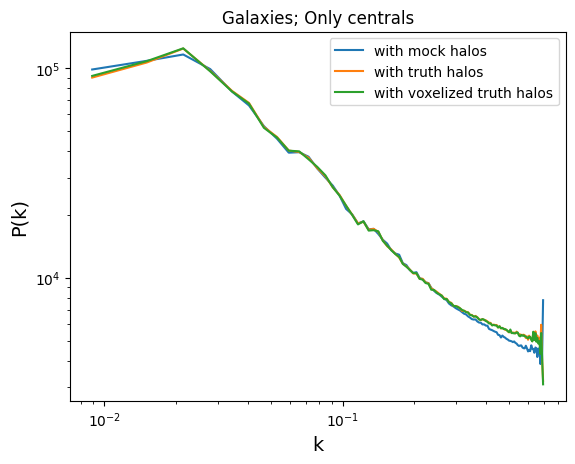

In [64]:
pl.figure()
pl.plot(Pk_mock.k3D, Pk_g_mock.Pk[:,0], label='with mock halos')
pl.plot(Pk_g_truth.k3D, Pk_g_truth.Pk[:,0], label='with truth halos')
pl.plot(Pk_g_truth_vox.k3D, Pk_g_truth_vox.Pk[:,0], label='with voxelized truth halos')

# pl.axhline(shot_noise_g_mock, color='k', linestyle='--')
# pl.axhline(shot_noise_g_truth, color='k', linestyle='--')
# pl.axhline(shot_noise_g_truth_vox, color='k', linestyle='--')

pl.xscale('log')
pl.yscale('log')
pl.legend()
# pl.ylim(1e3, 5e5)
pl.xlabel(r'k', size=14)
pl.ylabel(r'P(k)', size=14)
# pl.title(r'Galaxies')
# pl.title(r'Galaxies; Low Satellite fraction')
pl.title(r'Galaxies; Only centrals')



(0.6, 1.4)

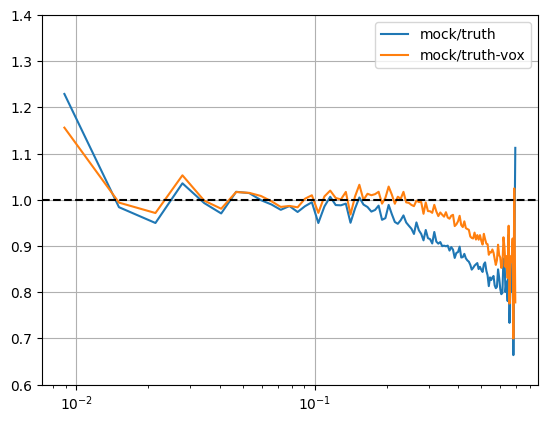

In [54]:
pl.figure()
pl.plot(Pk_mock.k3D, Pk_g_mock.Pk[:,0]/Pk_g_truth.Pk[:,0], label='mock/truth')
pl.plot(Pk_g_truth.k3D, Pk_g_mock.Pk[:,0]/Pk_g_truth_vox.Pk[:,0], label='mock/truth-vox')
# pl.plot(Pk_g_truth_vox.k3D, Pk_g_truth_vox.Pk[:,0], label='truth vox')

# pl.axhline(shot_noise_g_mock, color='k', linestyle='--')
# pl.axhline(shot_noise_g_truth, color='k', linestyle='--')
# pl.axhline(shot_noise_g_truth_vox, color='k', linestyle='--')

pl.xscale('log')
# pl.yscale('log')
pl.axhline(1.0, color='k', linestyle='--')
pl.grid()
pl.legend()
pl.ylim(0.6,1.4)
# pl.ylim(1e3, 5e5)




In [115]:
Mmin_Pk, Mmax_Pk = 13.0, 16.0
indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
print(Mmin_Pk, Mmax_Pk, ', number in truth:,', len(indsel_Pk_truth))
shot_noise_truth2 = BoxSize**3/len(indsel_Pk_truth)
mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float32);  mesh_truth2 -= 1.0
Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)


# Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]
indsel_Pk_truth = np.where((lgmass_truth_orig > Mmin_Pk) & (lgmass_truth_orig < Mmax_Pk))[0]
print(Mmin_Pk, Mmax_Pk, ', number in truth:,', len(indsel_Pk_truth))
shot_noise_truth = BoxSize**3/len(indsel_Pk_truth)
mesh_truth = np.zeros((grid, grid, grid), dtype=np.float32)
pos_truth = (pos_h_truth_orig[indsel_Pk_truth,...]).astype(np.float32)
MASL.MA(pos_truth, mesh_truth, BoxSize, MAS)
mesh_truth /= np.mean(mesh_truth, dtype=np.float32);  mesh_truth -= 1.0
Pk_truth = PKL.Pk(mesh_truth, BoxSize, axis=0, MAS=None, threads=1)




13.0 16.0 , number in truth:, 103893

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.05 seconds
13.0 16.0 , number in truth:, 103894

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.05 seconds


(1000.0, 500000.0)

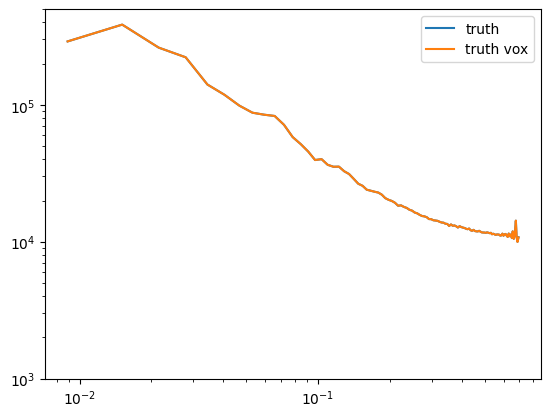

In [116]:
pl.figure()
# pl.plot(Pk_mock.k3D, Pk_g_mock.Pk[:,0], label='mock')
pl.plot(Pk_truth.k3D, Pk_truth.Pk[:,0], label='truth')
pl.plot(Pk_truth2.k3D, Pk_truth2.Pk[:,0], label='truth vox')
pl.xscale('log')
pl.yscale('log')
pl.legend()
pl.ylim(1e3, 5e5)





29372

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.05 seconds
29413

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.05 seconds


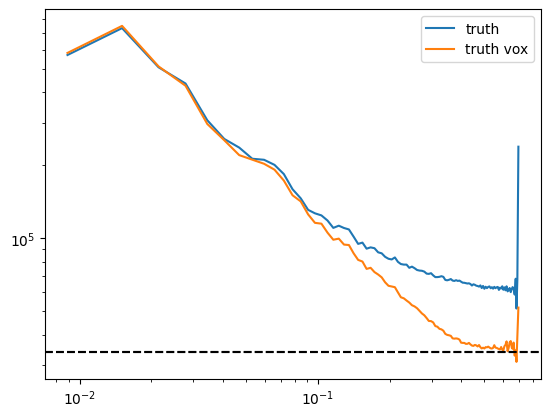

In [135]:
cosmo_LH = LH_cosmo_val_all[test_LH_id]

lgMsel_min, lgMsel_max = 13.5, 14.5

redshift = 0.5
params_LH = {'flat': True, 'H0': 100*cosmo_LH[2], 'Om0': cosmo_LH[0], 'Ob0': cosmo_LH[1], 'sigma8': cosmo_LH[4], 'ns': cosmo_LH[3]}
cosmo_LH = cosmology.setCosmology('myCosmo', **params_LH)
indsel = np.where((lgMass_truth > lgMsel_min) & (lgMass_truth < lgMsel_max))[0]
c200c_truth = concentration.concentration(10**lgMass_truth[indsel], '200c', redshift, model = 'diemer15')
R200c_truth = mass_so.M_to_R(10**lgMass_truth[indsel], redshift, '200c')/1000.

pos_g_truth_vox = get_HOD_mock(pos_h_truth[indsel,:], 10**lgMass_truth[indsel], R200c_truth, c200c_truth)
print(len(pos_g_truth_vox))
mesh_truth_vox = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA((pos_g_truth_vox).astype(np.float32), mesh_truth_vox, BoxSize, MAS)
mesh_truth_vox /= np.mean(mesh_truth_vox, dtype=np.float32);  mesh_truth_vox -= 1.0
Pk_g_truth_vox = PKL.Pk(mesh_truth_vox, BoxSize, axis=0, MAS=None, threads=1)  

shot_noise_g_truth_vox = BoxSize**3/len(pos_g_truth_vox)  



cosmo_LH = LH_cosmo_val_all[test_LH_id]
redshift = 0.5
params_LH = {'flat': True, 'H0': 100*cosmo_LH[2], 'Om0': cosmo_LH[0], 'Ob0': cosmo_LH[1], 'sigma8': cosmo_LH[4], 'ns': cosmo_LH[3]}
cosmo_LH = cosmology.setCosmology('myCosmo', **params_LH)
indsel = np.where((lgmass_truth_orig > lgMsel_min) & (lgmass_truth_orig < lgMsel_max))[0]
c200c_truth = concentration.concentration(10**lgmass_truth_orig[indsel], '200c', redshift, model = 'diemer15')
R200c_truth = mass_so.M_to_R(10**lgmass_truth_orig[indsel], redshift, '200c')/1000.
pos_g_truth = get_HOD_mock(pos_h_truth_orig[indsel], 10**lgmass_truth_orig[indsel], R200c_truth, c200c_truth)
print(len(pos_g_truth))
mesh_truth = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA((pos_g_truth).astype(np.float32), mesh_truth, BoxSize, MAS)
mesh_truth /= np.mean(mesh_truth, dtype=np.float32);  mesh_truth -= 1.0
Pk_g_truth = PKL.Pk(mesh_truth, BoxSize, axis=0, MAS=None, threads=1)  

shot_noise_g_truth = BoxSize**3/len(pos_g_truth)  



pl.figure()
# pl.plot(Pk_mock.k3D, Pk_g_mock.Pk[:,0], label='mock')
pl.plot(Pk_g_truth.k3D, Pk_g_truth.Pk[:,0], label='truth')
pl.plot(Pk_g_truth_vox.k3D, Pk_g_truth_vox.Pk[:,0], label='truth vox')

# pl.axhline(shot_noise_g_mock, color='k', linestyle='--')
pl.axhline(shot_noise_g_truth, color='k', linestyle='--')
pl.axhline(shot_noise_g_truth_vox, color='k', linestyle='--')

pl.xscale('log')
pl.yscale('log')
pl.legend()
# pl.ylim(1e3, 5e5)




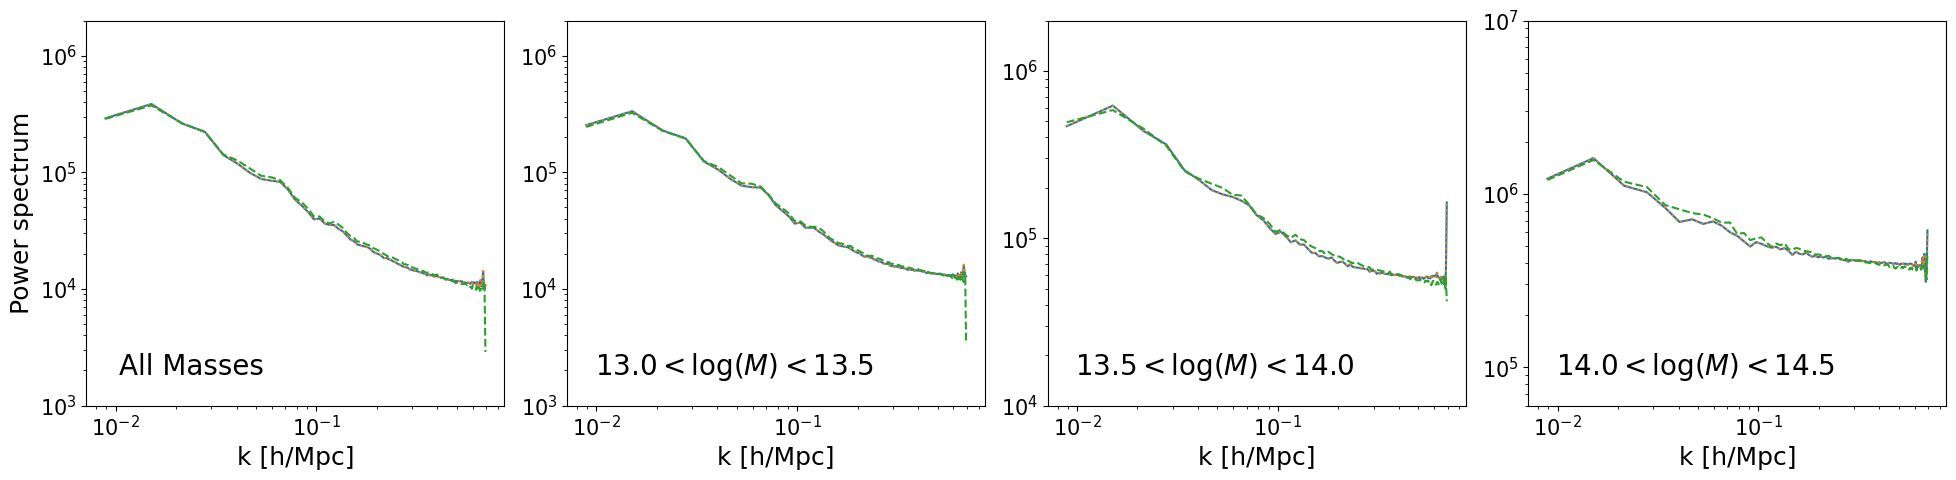

In [105]:
fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=False, sharex=True, gridspec_kw={'wspace': 0.15, 'hspace': 0})
for idim in range(4):
    # M_idim_truth = df_Mh_all_truth[..., idim]
    # hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
    if idim == 0:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_truth_vox'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_truth_orig'], ls=':')        
        ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock'], ls='--')
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mockxtruth'], ls=':')
        ax[idim].text(0.25, 0.1, 'All Masses', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_ylim(1e3, 2e5)
        ax[idim].set_ylim(1e3, 2e6)
    
    if idim == 1:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_truth_vox'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_truth_orig'], ls=':')                
        ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mock'], ls='--')
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mockxtruth'], ls=':')
        # ax[idim].text(0.25, 0.1, MAS_all[1][0] + '; ' + str(MAS_all[1][1]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_ylim(1e3, 2e5)
        ax[idim].set_ylim(1e3, 2e6)
    if idim == 2:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_truth_vox'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_truth_orig'], ls=':')                
        ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mock'], ls='--')
        ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mockxtruth'], ls=':')
        # ax[idim].text(0.25, 0.1, MAS_all[2][0] + '; ' + str(MAS_all[2][1]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_ylim(1e4, 2e5)
        ax[idim].set_ylim(1e4, 2e6)
    if idim == 3:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_truth_vox'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_truth_orig'], ls=':')                
        ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mock'], ls='--')
        ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mockxtruth'], ls=':')
        # ax[idim].text(0.25, 0.1, MAS_all[3][0] + '; ' + str(MAS_all[3][1]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_ylim(1e4, 1e6)
        ax[idim].set_ylim(6e4, 1e7)
    ax[idim].set_yscale('log')
    ax[idim].set_xscale('log')  
    # ax[idim].grid()  
    ax[idim].tick_params(axis='both', which='major', labelsize=15)
    ax[idim].tick_params(axis='both', which='minor', labelsize=15)
    ax[idim].set_xlabel('k [h/Mpc]', size=18)
    
    if idim == 0:
        ax[idim].set_ylabel('Power spectrum', size=18)

    # ax[idim].set_ylim(1e3, 1e5)


    

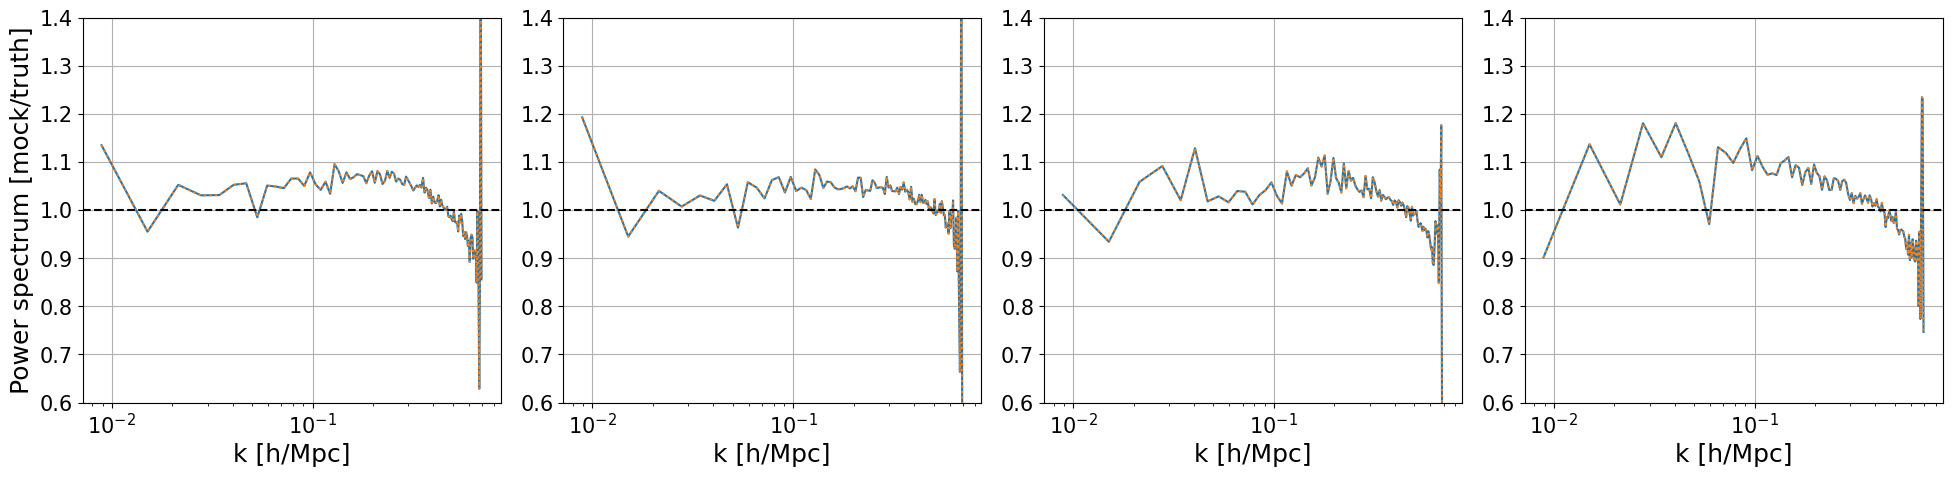

In [33]:
fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=False, sharex=True, gridspec_kw={'wspace': 0.15, 'hspace': 0})
for idim in range(4):
    # M_idim_truth = df_Mh_all_truth[..., idim]
    # hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
    if idim == 0:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock']/saved_all_jsim['Pk_Bk'][0]['Pk_truth_vox'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock']/saved_all_jsim['Pk_Bk'][0]['Pk_truth_orig'], ls=':')        
    if idim == 1:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mock']/saved_all_jsim['Pk_Bk'][1]['Pk_truth_vox'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mock']/saved_all_jsim['Pk_Bk'][1]['Pk_truth_orig'], ls=':')                
    if idim == 2:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mock']/saved_all_jsim['Pk_Bk'][2]['Pk_truth_vox'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mock']/saved_all_jsim['Pk_Bk'][2]['Pk_truth_orig'], ls=':')                
    if idim == 3:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mock']/saved_all_jsim['Pk_Bk'][3]['Pk_truth_vox'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mock']/saved_all_jsim['Pk_Bk'][3]['Pk_truth_orig'], ls=':')                
    # ax[idim].set_yscale('log')
    ax[idim].set_xscale('log')  
    # ax[idim].grid()  
    ax[idim].tick_params(axis='both', which='major', labelsize=15)
    ax[idim].tick_params(axis='both', which='minor', labelsize=15)
    ax[idim].set_xlabel('k [h/Mpc]', size=18)
    
    if idim == 0:
        ax[idim].set_ylabel('Power spectrum [mock/truth]', size=18)

    ax[idim].axhline(1.0, ls='--', color='k')
    ax[idim].set_ylim(0.6, 1.4)
    ax[idim].grid()


    



In [ ]:
import h5py as h5

import os 
import numpy as np 
import nbodykit.lab as NBlab
from astropy.utils.misc import NumpyRNGContext
from nbodykit.hod import Zheng07Model, HODModel





In [24]:
import readfof
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL
import yaml

print(loss_min, epoch_tot_counter, stype)

train_Ntot, train_M1, train_Mdiff = 1, 1, 1
train_binary=1
train_multi=1
# train_Ntot, train_M1, train_Mdiff = 1, 1, 0
# train_Ntot, train_M1, train_Mdiff = 1, 0, 0
isim_start = 1024
isim_end = 1032
isim_all = np.arange(isim_start, isim_end).astype(int)


saved_all_test = {}

for ji in range(len(isim_all)):
    saved_all_jsim = {}
    # now we load the test data
    isim = isim_all[ji]
    print('DOING SIM NUMBER:' + str(isim))
    nstart = 0
    nsims_test = 32
    df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test, ind_subsel_all_test, ind_subsel_fid_test, cosmo_val_all_test = load_density_halo_data_NGP(
        [isim], ns_d, nb, nf, nc, z_all, ns_h, z_inference=z_inference, nsubvol_per_ji=512, nsubvol_fid=0,
        # sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH',
        sdir_cosmo='/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH',
        sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
        LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt',                  
        subsel_criteria='all',
        stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, is_HR=is_HR
        )

    if cond_sim == 'fastpm':
        df_d_all_test_FP, df_d_all_nsh_test_FP, df_Mh_all_test_FP, df_Nh_test_FP, _, _, cosmo_val_all_test_FP = load_density_halo_data_NGP(
            [isim], ns_d, nb, nf, nc, z_all_FP, ns_h, z_inference=z_inference, nsubvol_per_ji=512, nsubvol_fid=0,
            sdir_cosmo='/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH',
            sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm',  
            LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt',  
            subsel_criteria='all',
            stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, 
            # indsubsel_all_inp=ind_subsel_all_test,
            # indsubsel_fid_inp=ind_subsel_fid_test,
            is_HR = is_HR
            )

    # things are too big to load all at once, so we load in batches
    nq = nb**3 // nsims_test
    save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_M1_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    save_subvol_Mdiff_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    mask_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))

    # nfeatures_M1_tot = 20
    # cond_inp_M1_all = np.zeros((nb**3, nax_h, nax_h, nax_h, nfeatures_M1_tot))
    density_out_M1_loc_all_pad = np.zeros((nb**3, nax_h+6, nax_h+6, nax_h+6))
    density_out_M1_loc_all = np.zeros((nb**3, nax_h, nax_h, nax_h))

    nscount = 0
    for jq in range(nq):

        # Load the density data


        # Prepare the density and halo data
        return_dict_test = prep_density_halo_cats(
            df_d_all_test,
            df_d_all_nsh_test,
            df_Mh_all_test,
            df_Nh_test,
            cosmo_val_all_test,
            nsims=nsims_test,
            nstart=nscount,
            Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax
            )
        
        if cond_sim == 'fastpm':
            return_dict_test_FP = prep_density_halo_cats(
                df_d_all_test_FP,
                df_d_all_nsh_test_FP,
                df_Mh_all_test_FP,
                df_Nh_test_FP,
                cosmo_val_all_test_FP,
                nsims=nsims_test,
                nstart=nscount,
                Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
                )    

        if cond_sim == 'fastpm':
            cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test_FP['df_d_all']]))).cuda(dev)
            cond_nsh_test = np.moveaxis(return_dict_test_FP['df_d_all_nsh'], 1, 4)
            cond_nsh_test = np.array([cond_nsh_test])
            cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
            cosmo_cond_test = torch.Tensor(np.copy(return_dict_test_FP['cosmo_val_all']))
            cosmo_cond_test = cosmo_cond_test.reshape(1,nsims_test * (nax_h**3), cosmo_cond_test.shape[-1])
            cond_cosmo_test = cosmo_cond_test.cuda(dev)
        else:
            cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test['df_d_all']]))).cuda(dev)
            cond_nsh_test = np.moveaxis(return_dict_test['df_d_all_nsh'], 1, 4)
            cond_nsh_test = np.array([cond_nsh_test])
            cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)
            cosmo_cond_test = torch.Tensor(np.copy(return_dict_test['cosmo_val_all']))
            cosmo_cond_test = cosmo_cond_test.reshape(1,nsims_test * (nax_h**3), cosmo_cond_test.shape[-1])
            cond_cosmo_test = cosmo_cond_test.cuda(dev)

        mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
        mask_tensor_Mdiff_test = torch.Tensor(
            (return_dict_test['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            ).cuda(dev)

        X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
        X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
        X_Mdiff_test = torch.Tensor(
            return_dict_test['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            ).cuda(dev)
        Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                        1)))).cuda(dev)
        

        binary_mask_tensor_test = torch.zeros_like(Nhalos_truth_tensor_test)
        ind_gt = torch.where(Nhalos_truth_tensor_test > 0)
        binary_mask_tensor_test[ind_gt] = 1
        X_binary_int_test = binary_mask_tensor_test.to(dev)
        X_binary_test = return_dict_test['sig_all'][0] * torch.randn(X_binary_int_test.shape[0], X_binary_int_test.shape[1], X_binary_int_test.shape[2], device=dev) + (X_binary_int_test) + 1

        X_multiclass_int_test = ((Nhalos_truth_tensor_test).to(torch.long)).to(dev)
        X_multiclass_test = return_dict_test['sig_all'][0] * torch.randn(X_multiclass_int_test.shape[0], X_multiclass_int_test.shape[1], X_multiclass_int_test.shape[2], device=dev) + (X_multiclass_int_test)

        # Nhalos_truth_tensor = Nhalos_truth_tensor.cuda(dev)
        # indsel_Nhalo_gt1_test = []
        # for jb in range((mask_tensor_Mdiff_train.shape[0])):
            # indsel_Nhalo_gt1.append(torch.where(Nhalos_truth_tensor[jb,:,0] > 1)[0])
        # indsel_Nhalo_gt2.shape



        if cond_sim == 'fastpm':
            mask_tensor_M1_test_FP = torch.Tensor(np.copy(return_dict_test_FP['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
            # mask_tensor_Mdiff_test_FP = torch.Tensor(
            #     (return_dict_test_FP['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            #     ).cuda(dev)

            X_M1_test_FP = torch.Tensor((return_dict_test_FP['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
            X_Nhalo_test_FP = torch.Tensor(return_dict_test_FP['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
            # X_Mdiff_test_FP = torch.Tensor(
            #     return_dict_test_FP['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            #     ).cuda(dev)
            Nhalos_truth_tensor_test_FP = torch.Tensor(((return_dict_test_FP['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                            1)))).cuda(dev)
        else:
            mask_tensor_M1_test_FP = None
            mask_tensor_Mdiff_test_FP = None
            X_M1_test_FP = None
            X_Nhalo_test_FP = None
            X_Mdiff_test_FP = None
            Nhalos_truth_tensor_test_FP = None

        Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, cond_inp_M1_test = model.inverse(
            cond_x=cond_tensor_test,
            cond_x_nsh=cond_tensor_nsh_test,
            cond_cosmo=cond_cosmo_test,
            use_truth_Nhalo=1-train_Ntot,
                use_truth_M1=1-train_M1,
                use_truth_Mdiff=1-train_Mdiff, 
            mask_Mdiff_truth=mask_tensor_Mdiff_test,
            mask_M1_truth=mask_tensor_M1_test,
            Nhalos_truth=X_Nhalo_test,
            M1_truth=X_M1_test,
            Mdiff_truth=X_Mdiff_test,
            # train_Ntot=train_Ntot,
            train_binary=train_binary,
            train_multi=train_multi,   
            train_M1=train_M1,
            train_Mdiff=train_Mdiff,
            # x_M1_FP=X_M1_test_FP,   
            # mask_M1_truth_all_FP=mask_tensor_M1_test_FP 
            )
        Ntot_samp_test = Ntot_samp_test[0][:,np.newaxis]
        # print(Ntot_samp_test.shape)
        save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_M1[nscount:nscount + nsims_test,
                    ...] = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:,0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
        save_subvol_M1_truth[nscount:nscount + nsims_test,
                    ...] = (X_M1_test[0][:,0] * mask_tensor_M1_test[0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)    
        # cond_inp_M1_all[nscount:nscount + nsims_test,
        #                ...] = cond_inp_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, nfeatures_M1_tot)
        # density_out_M1_loc_all_pad[nscount:nscount + nsims_test,...] = (cond_tensor_test[0,:,0,...].cpu().detach().numpy())
        # density_out_M1_loc_all[nscount:nscount + nsims_test,...] = (cond_nsh_test[0,...,0])

        save_subvol_Mdiff[nscount:nscount + nsims_test,
                        ...] = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        save_subvol_Mdiff_truth[nscount:nscount + nsims_test,
                        ...] = (X_Mdiff_test[0] * mask_tensor_Mdiff_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

        mask_subvol_Mtot_truth[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot_truth[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        
        cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
        # print(nscount, nscount + nsims_test)

        nscount += nsims_test
        torch.cuda.empty_cache()


    save_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot[..., jd] = (save_subvol_M1[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot[...,
                            jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot *= mask_subvol_Mtot

    # ind_less_Mmin = save_subvol_Mtot < Mmin
    # ind_greater_Mmax = save_subvol_Mtot > Mmax
    # save_subvol_Mtot[ind_less_Mmin] = 0.0
    # save_subvol_Mtot[ind_greater_Mmax] = 0.0


    save_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot_truth[..., jd] = (save_subvol_M1_truth[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot_truth[...,
                            jd] = (save_subvol_Mtot_truth[..., jd - 1]) - (save_subvol_Mdiff_truth[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot_truth *= mask_subvol_Mtot_truth
                

    sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH'
    # load the halo data
    if is_HR:
        fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    else:
        fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    df_h_subvol = pk.load(open(fname, 'rb'))
    # This has information on the halo mass for all the halos in the voxel
    df_Mh_all_truth = df_h_subvol['M_halos']
    df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # This has information on the number of halos in the voxel
    df_Nh_truth = df_h_subvol['N_halos']
    df_Nh_truth = np.clip(df_Nh_truth, 0, Nmax)

    if is_HR:
        fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
    else:
        fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
    df_h_full = pk.load(open(fname, 'rb'))
    df_Mh_all_truth_comb, df_Nh_truth_comb = df_h_full['M_halos_combined'], df_h_full['N_halos_combined']
    df_Nh_truth_comb = np.clip(df_Nh_truth_comb, 0, Nmax)

    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1

    bin_cents = np.array(np.arange(Nmax + 1))
    bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
    bin_edges = np.insert(bin_edges,0, -0.5)
    bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
    saved_all_jsim['Nhalo_bin_cents'] = bin_cents
    saved_all_jsim['Nhalo_bin_edges'] = bin_edges

    delta_min_p, delta_max_p= -1.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_all, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_all, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_all_Nhalo'] = hist_truth_all
    saved_all_jsim['hist_samp_all_Nhalo'] = hist_samp_all
    print(hist_samp_all)
    print(hist_truth_all)

    delta_min_p, delta_max_p= -1.0, 0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_low, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_low, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_low_Nhalo'] = hist_truth_low
    saved_all_jsim['hist_samp_low_Nhalo'] = hist_samp_low

    delta_min_p, delta_max_p= 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_mid, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_mid, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_mid_Nhalo'] = hist_truth_mid
    saved_all_jsim['hist_samp_mid_Nhalo'] = hist_samp_mid

    delta_min_p, delta_max_p= 2.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_high, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_high, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_high_Nhalo'] = hist_truth_high
    saved_all_jsim['hist_samp_high_Nhalo'] = hist_samp_high


    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
    bin_cents_M = np.linspace(lgMmin, lgMmax, 20)[1:-1]
    bin_edges_M = 0.5*(bin_cents_M[1:] + bin_cents_M[:-1])
    delta_b = 0.5*(bin_cents_M[1] - bin_cents_M[0])
    bin_edges_M = np.insert(bin_edges_M,0, bin_cents_M[0] - delta_b)
    bin_edges_M = np.insert(bin_edges_M,len(bin_edges_M), bin_cents_M[-1] + delta_b)
    saved_all_jsim['Mhalo_bin_cents'] = bin_cents_M
    saved_all_jsim['Mhalo_bin_edges'] = bin_edges_M


    delta_min_p, delta_max_p = -1.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_all = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_all = np.zeros((4, len(bin_cents_M)))    
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_all[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_all[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_all_Mhalo'] = hist_M_truth_all
    saved_all_jsim['hist_samp_all_Mhalo'] = hist_M_samp_all

    delta_min_p, delta_max_p = -1.0, 0.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_low = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_low = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_low[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_low[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_low_Mhalo'] = hist_M_truth_low
    saved_all_jsim['hist_samp_low_Mhalo'] = hist_M_samp_low

    delta_min_p, delta_max_p = 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_mid = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_mid = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_mid[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_mid[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_mid_Mhalo'] = hist_M_truth_mid
    saved_all_jsim['hist_samp_mid_Mhalo'] = hist_M_samp_mid

    delta_min_p, delta_max_p = 2.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_high = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_high = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_high[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_high[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_high_Mhalo'] = hist_M_truth_high
    saved_all_jsim['hist_samp_high_Mhalo'] = hist_M_samp_high

    # # import pdb; pdb.set_trace()

    saved_all_jsim['cosmology'] = cosmo_val_all_test[0,0,0,0,:]

    # # create empty arrays for Nhalos and M_halos
    Nhalos = np.zeros((ns_h, ns_h, ns_h))
    M_halos = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))
    M_halos_truth = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    subvol_size = ns_h // nb

    ind_cart_lin = {}
    ind_lin_cart = {}
    jc = 0
    from tqdm import tqdm
    for jx in tqdm(range(nb)):
        for jy in range(nb):
            for jz in range(nb):
                # get the sub-cube
                ind_lin_cart[(jx, jy, jz)] = jc
                ind_cart_lin[jc] = [jx, jy, jz]
                jc += 1
                

    # iterate over subvolumes
    jc = 0
    for jx in range(nb):
        for jy in range(nb):
            for jz in range(nb):
                Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[ind_lin_cart[(jx, jy, jz)]]

                M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                        jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[ind_lin_cart[(jx, jy, jz)]]
                
                
                jc += 1
                
                
    
    # create empty arrays for Nhalos and M_halos
    Nhalos_truth_recomb = np.zeros((ns_h, ns_h, ns_h))
    M_halos_truth_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    subvol_size = ns_h // nb

    ind_cart_lin = {}
    ind_lin_cart = {}
    jc = 0
    from tqdm import tqdm
    for jx in tqdm(range(nb)):
        for jy in range(nb):
            for jz in range(nb):
                # get the sub-cube
                ind_lin_cart[(jx, jy, jz)] = jc
                ind_cart_lin[jc] = [jx, jy, jz]
                jc += 1
                

    # iterate over subvolumes
    jc = 0
    for jx in range(nb):
        for jy in range(nb):
            for jz in range(nb):
                Nhalos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo_truth[ind_lin_cart[(jx, jy, jz)]]

                M_halos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                        jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot_truth[ind_lin_cart[(jx, jy, jz)],...,:ndim_diff + 1]
                
                
                jc += 1
                

    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')


    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    dx = (xall[1] - xall[0])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
    # Nmax_sel = 3
    k = 0
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                    Nh_vox = int(Nhalos[jx, jy, jz])
                    if Nh_vox > 0:
                        # if Nh_vox > Nmax_sel:
                        #     Nh_vox = Nmax_sel

                        x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                        y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                        z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
                        lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                        k += Nh_vox

    # convert to numpy arrays
    x_h_mock = np.concatenate(x_h_mock)
    y_h_mock = np.concatenate(y_h_mock)
    z_h_mock = np.concatenate(z_h_mock)
    pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
    lgMass_mock = np.concatenate(lgM_mock)
    # convert to float data type
    pos_h_mock = pos_h_mock.astype('float32')
    lgMass_mock = lgMass_mock.astype('float32')


    x_h_truth, y_h_truth, z_h_truth, lgM_truth = [], [], [], []
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                    Nh_vox = int(Nhalos_truth_recomb[jx, jy, jz])
                    # Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])                    
                    if Nh_vox > 0:
                        # if Nh_vox > Nmax_sel:
                        #     Nh_vox = Nmax_sel

                        x_h_truth.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                        y_h_truth.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                        z_h_truth.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
                        lgM_truth.append((M_halos_truth_recomb[jx, jy, jz, :Nh_vox]))
                        # lgM_truth.append((df_Mh_all_truth_comb[jx, jy, jz, :Nh_vox]))

    # convert to numpy arrays
    x_h_truth = np.concatenate(x_h_truth)
    y_h_truth = np.concatenate(y_h_truth)
    z_h_truth = np.concatenate(z_h_truth)
    pos_h_truth = np.vstack((x_h_truth, y_h_truth, z_h_truth)).T
    lgMass_truth = np.concatenate(lgM_truth)
    # convert to float data type
    pos_h_truth = pos_h_truth.astype('float32')
    lgMass_truth = lgMass_truth.astype('float32')

    grid    = ns_h    #the 3D field will have grid x grid x grid voxels
    BoxSize = 1000.0 #Mpc/h ; size of box
    MAS     = 'NGP'  #mass-assigment scheme
    verbose = False   #print information on progress

    Mmin_Pk_all = np.array([13.0, 13.0, 13.5, 14.0, 14.5])
    Mmax_Pk_all = np.array([16.0, 13.5, 14.0, 14.5, 15.0])
    # Mmin_Pk_all = np.log10(np.array([1e13, 5e13, 7e13, 1e14, 5e14]))
    # Mmax_Pk_all = np.log10(np.array([1e17, 7e13, 1e14, 5e14, 1e15]))  
    Mmin_Pk_all[0] = -1.0
    # MAS_all = [['NGP',None], 
    # ['NGP','NGP'], ['CIC', None], ['CIC','CIC']]
    # Mmin_Pk_all = -1.0
    # Mmax_Pk_all = 100.0

    saved_Pk_Bk = {}

    for j in range(len(Mmin_Pk_all)):
        saved_j = {}
        # Mmin_Pk, Mmax_Pk = Mmin_Pk_all, Mmax_Pk_all
        Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]
        indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
        print(Mmin_Pk, Mmax_Pk, ', number in truth:,', len(indsel_Pk_truth))
        mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
        pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
        MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
        mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float32);  mesh_truth2 -= 1.0
        Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)

        indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
        print(Mmin_Pk, Mmax_Pk, ' number in mock:,', len(indsel_Pk_mock))        
        mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
        pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
        MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
        mesh_mock /= np.mean(mesh_mock, dtype=np.float32);  mesh_mock -= 1.0
        Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)    

        Pk_mockxtruth2 = PKL.XPk([mesh_truth2,mesh_mock], BoxSize, axis=0, MAS=[None, None], threads=1)

        saved_j['Pk_truth'] = Pk_truth2.Pk[:,0]
        saved_j['Pk_mock'] = Pk_mock.Pk[:,0]
        saved_j['Pk_mockxtruth'] = Pk_mockxtruth2.XPk[:,0,0]
        saved_j['k_Pk'] = Pk_mockxtruth2.k3D
        

        saved_Pk_Bk[j] = saved_j

    saved_all_jsim['Pk_Bk'] = saved_Pk_Bk

    saved_all_test[ji] = saved_all_jsim




-6.538254737854004 28506 cic
DOING SIM NUMBER:1024


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


[2052333   38169    5389    1000     203      46       9       2       1]
[2023356   61210    9979    1988     472      96      36      12       3]


100%|██████████| 8/8 [00:00<00:00, 43804.74it/s]


-1.0 16.0 , number in truth:, 55479

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.07 seconds
-1.0 16.0  number in mock:, 53065

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.0 13.5 , number in truth:, 48334

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.0 13.5  number in mock:, 45447

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.5 14.0 , number in truth:, 6674

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.5 14.0  number in mock:, 6668

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Compu

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


[1578411  333811  115353   42841   16425    6074    2577    1007     653]
[1536028  346634  128166   50624   20494    8547    3737    1616    1306]


100%|██████████| 8/8 [00:00<00:00, 44858.87it/s]


-1.0 16.0 , number in truth:, 821567

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.07 seconds
-1.0 16.0  number in mock:, 816845

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.04
Time loop = 0.04
Time taken = 0.08 seconds
13.0 13.5 , number in truth:, 613806

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.0 13.5  number in mock:, 596799

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.5 14.0 , number in truth:, 174421

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.5 14.0  number in mock:, 178960

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.07 second

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


[1779422  227243   62277   18946    6179    1977     724     245     139]
[1747046  242992   71408   23082    7916    2916    1094     428     270]


100%|██████████| 8/8 [00:00<00:00, 45221.61it/s]


-1.0 16.0 , number in truth:, 453444

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds
-1.0 16.0  number in mock:, 450407

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.08 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.0 13.5 , number in truth:, 348528

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.0 13.5  number in mock:, 337190

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.5 14.0 , number in truth:, 89191

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.5 14.0  number in mock:, 93289

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


[1653629  296885   94844   32937   11969    4264    1573     651     400]
[1604212  315454  109753   40931   15826    6384    2554    1151     887]


100%|██████████| 8/8 [00:00<00:00, 40970.00it/s]


-1.0 16.0 , number in truth:, 680468

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.08 seconds
-1.0 16.0  number in mock:, 671775

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.08 seconds

Computing power spectra of the fields...
Time FFTS = 0.04
Time loop = 0.04
Time taken = 0.08 seconds
13.0 13.5 , number in truth:, 518179

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.07 seconds
13.0 13.5  number in mock:, 500087

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.5 14.0 , number in truth:, 138019

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.5 14.0  number in mock:, 141364

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 second

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


[1909359  148437   29994    7019    1744     442     108      37      12]
[1828639  199079   49701   13812    4050    1261     421     132      57]


100%|██████████| 8/8 [00:00<00:00, 45839.39it/s]


-1.0 16.0 , number in truth:, 236794

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.07 seconds
-1.0 16.0  number in mock:, 239671

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.0 13.5 , number in truth:, 203631

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.0 13.5  number in mock:, 201713

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.5 14.0 , number in truth:, 31083

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.5 14.0  number in mock:, 33605

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


[1904581  148428   32583    8442    2265     602     176      53      22]
[1834822  191569   49450   14529    4522    1490     490     181      99]


100%|██████████| 8/8 [00:00<00:00, 43351.98it/s]


-1.0 16.0 , number in truth:, 251323

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.08 seconds
-1.0 16.0  number in mock:, 252593

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.0 13.5 , number in truth:, 209297

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.0 13.5  number in mock:, 206626

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.5 14.0 , number in truth:, 38431

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.5 14.0  number in mock:, 40321

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


[1909712  139879   33651    9630    2914     903     298     110      55]
[1878426  159683   40741   12135    3976    1379     493     189     130]


100%|██████████| 8/8 [00:00<00:00, 41682.52it/s]


-1.0 16.0 , number in truth:, 252749

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.08 seconds
-1.0 16.0  number in mock:, 255240

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.0 13.5 , number in truth:, 195387

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.0 13.5  number in mock:, 194370

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.5 14.0 , number in truth:, 48585

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.5 14.0  number in mock:, 50121

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


[1952418  113545   23311    5759    1514     402     117      54      32]
[1930766  127835   28165    7233    2130     665     229      72      57]


100%|██████████| 8/8 [00:00<00:00, 38971.47it/s]


-1.0 16.0 , number in truth:, 192121

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.07 seconds
-1.0 16.0  number in mock:, 186846

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.0 13.5 , number in truth:, 151151

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.0 13.5  number in mock:, 142407

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds
13.5 14.0 , number in truth:, 35177

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds
13.5 14.0  number in mock:, 36943

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds


In [20]:
# !pip install --upgrade scipy



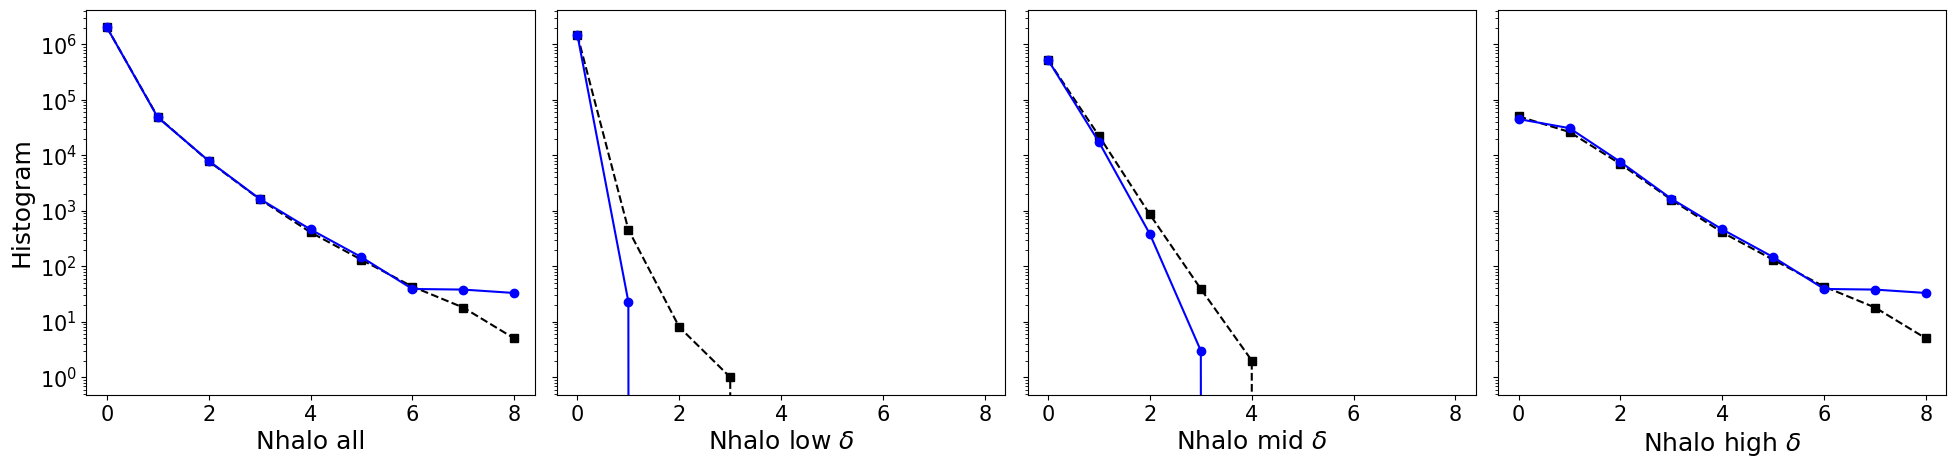

In [54]:
fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=True, sharex=True, gridspec_kw={'wspace': 0.05, 'hspace': 0})
for idim in range(4):
    # M_idim_truth = df_Mh_all_truth[..., idim]
    # hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
    if idim == 0:
        ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_all_Nhalo'], marker='s', color='k', ls='--', label='Truth')    
        ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_all_Nhalo'], marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Nhalo all', size=18)

    if idim == 1:
        ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_low_Nhalo'], marker='s', color='k', ls='--', label='Truth')    
        ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_low_Nhalo'], marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Nhalo low $\delta$', size=18)        

    if idim == 2:
        ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_mid_Nhalo'], marker='s', color='k', ls='--', label='Truth')    
        ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_mid_Nhalo'], marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Nhalo mid $\delta$', size=18)        

    if idim == 3:
        ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_high_Nhalo'], marker='s', color='k', ls='--', label='Truth')    
        ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_high_Nhalo'], marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Nhalo high $\delta$', size=18)        

    ax[idim].set_yscale('log')
    ax[idim].tick_params(axis='both', which='major', labelsize=15)
    ax[idim].tick_params(axis='both', which='minor', labelsize=15)
    
    if idim == 0:
        ax[idim].set_ylabel('Histogram', size=18)




        

/tmp/ipykernel_570366/391671619.py:11: RuntimeWarning: invalid value encountered in divide
  ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_low_Nhalo']/saved_all_jsim['hist_truth_low_Nhalo'], marker='s', color='k',  ls='-', lw=2,  label='Truth')
/tmp/ipykernel_570366/391671619.py:16: RuntimeWarning: invalid value encountered in divide
  ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_mid_Nhalo']/saved_all_jsim['hist_truth_mid_Nhalo'], marker='s', color='k',  ls='-', lw=2,  label='Truth')


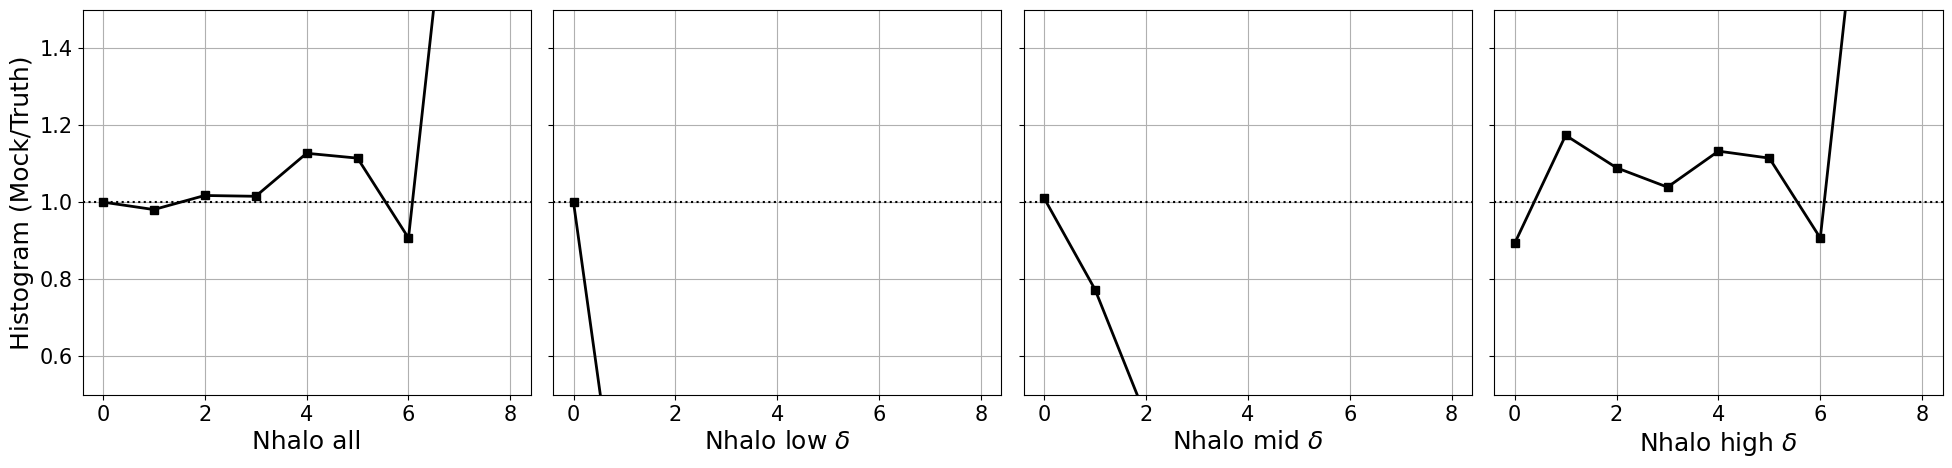

In [55]:
fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=True, sharex=True, gridspec_kw={'wspace': 0.05, 'hspace': 0})
for idim in range(4):
    # M_idim_truth = df_Mh_all_truth[..., idim]
    # hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
    if idim == 0:
        ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_all_Nhalo']/saved_all_jsim['hist_truth_all_Nhalo'], marker='s', color='k', ls='-', lw=2, label='Truth')    
        # ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], , marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Nhalo all', size=18)

    if idim == 1:
        ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_low_Nhalo']/saved_all_jsim['hist_truth_low_Nhalo'], marker='s', color='k',  ls='-', lw=2,  label='Truth')    
        # ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], , marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Nhalo low $\delta$', size=18)        

    if idim == 2:
        ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_mid_Nhalo']/saved_all_jsim['hist_truth_mid_Nhalo'], marker='s', color='k',  ls='-', lw=2,  label='Truth')    
        # ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], , marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Nhalo mid $\delta$', size=18)        

    if idim == 3:
        ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_high_Nhalo']/saved_all_jsim['hist_truth_high_Nhalo'], marker='s', color='k',  ls='-', lw=2,  label='Truth')    
        # ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], , marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Nhalo high $\delta$', size=18)        

    ax[idim].axhline(1.0, ls=':', color='k')
    ax[idim].tick_params(axis='both', which='major', labelsize=15)
    ax[idim].tick_params(axis='both', which='minor', labelsize=15)
    ax[idim].set_ylim(0.5, 1.5)
    ax[idim].grid()
    if idim == 0:
        ax[idim].set_ylabel('Histogram (Mock/Truth)', size=18)

        

In [38]:
saved_all_jsim['hist_truth_all_Mhalo'].shape



(4, 18)

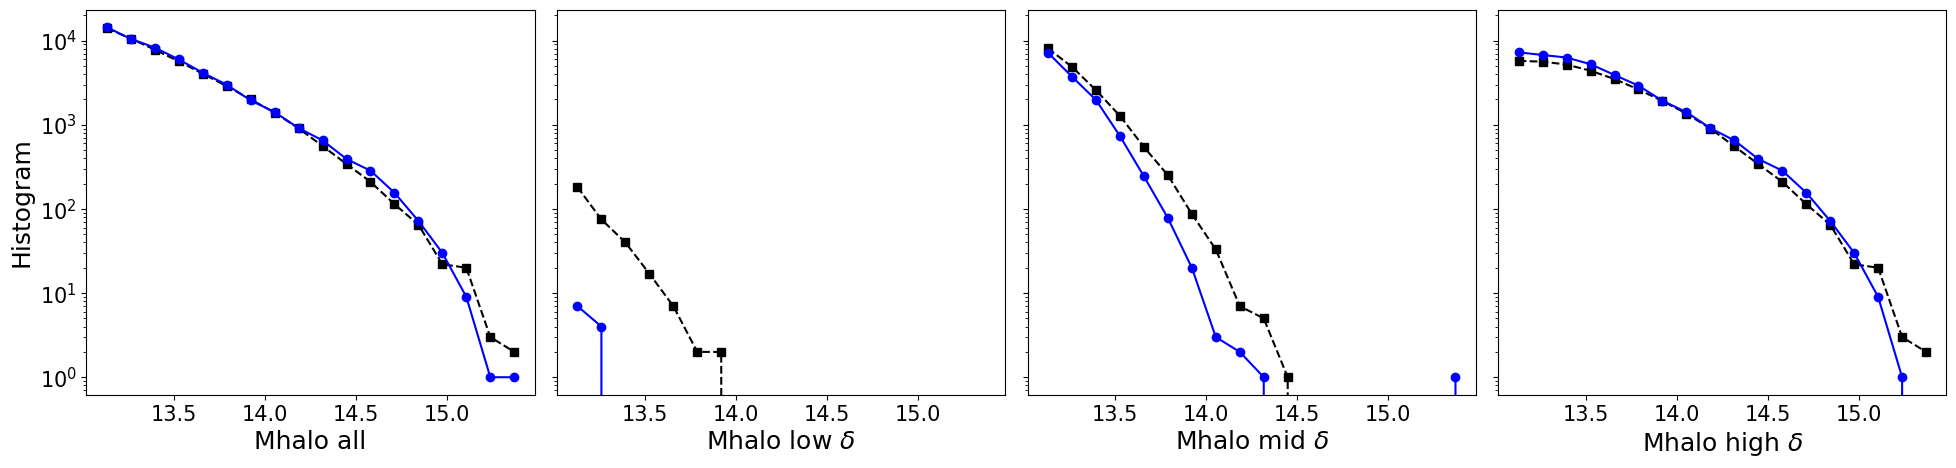

In [56]:
fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=True, sharex=True, gridspec_kw={'wspace': 0.05, 'hspace': 0})
jM = 0
for idim in range(4):
    # M_idim_truth = df_Mh_all_truth[..., idim]
    # hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
    if idim == 0:
        ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_all_Mhalo'][jM,:], marker='s', color='k', ls='--', label='Truth')    
        ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_all_Mhalo'][jM,:], marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Mhalo all', size=18)

    if idim == 1:
        ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_low_Mhalo'][jM,:], marker='s', color='k', ls='--', label='Truth')    
        ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_low_Mhalo'][jM,:], marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Mhalo low $\delta$', size=18)        

    if idim == 2:
        ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_mid_Mhalo'][jM,:], marker='s', color='k', ls='--', label='Truth')    
        ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_mid_Mhalo'][jM,:], marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Mhalo mid $\delta$', size=18)        

    if idim == 3:
        ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_high_Mhalo'][jM,:], marker='s', color='k', ls='--', label='Truth')    
        ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_high_Mhalo'][jM,:], marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Mhalo high $\delta$', size=18)        

    ax[idim].set_yscale('log')
    ax[idim].tick_params(axis='both', which='major', labelsize=15)
    ax[idim].tick_params(axis='both', which='minor', labelsize=15)
    
    if idim == 0:
        ax[idim].set_ylabel('Histogram', size=18)




        

/tmp/ipykernel_570366/3045485416.py:7: RuntimeWarning: divide by zero encountered in divide
  ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_all_Mhalo'][jM,:]/saved_all_jsim['hist_truth_all_Mhalo'][jM,:], marker='s', color='k', ls='--', label='Truth')
/tmp/ipykernel_570366/3045485416.py:7: RuntimeWarning: invalid value encountered in divide
  ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_all_Mhalo'][jM,:]/saved_all_jsim['hist_truth_all_Mhalo'][jM,:], marker='s', color='k', ls='--', label='Truth')
/tmp/ipykernel_570366/3045485416.py:12: RuntimeWarning: invalid value encountered in divide
  ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_low_Mhalo'][jM,:]/saved_all_jsim['hist_truth_low_Mhalo'][jM,:], marker='s', color='k', ls='--', label='Truth')
/tmp/ipykernel_570366/3045485416.py:17: RuntimeWarning: divide by zero encountered in divide
  ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['h

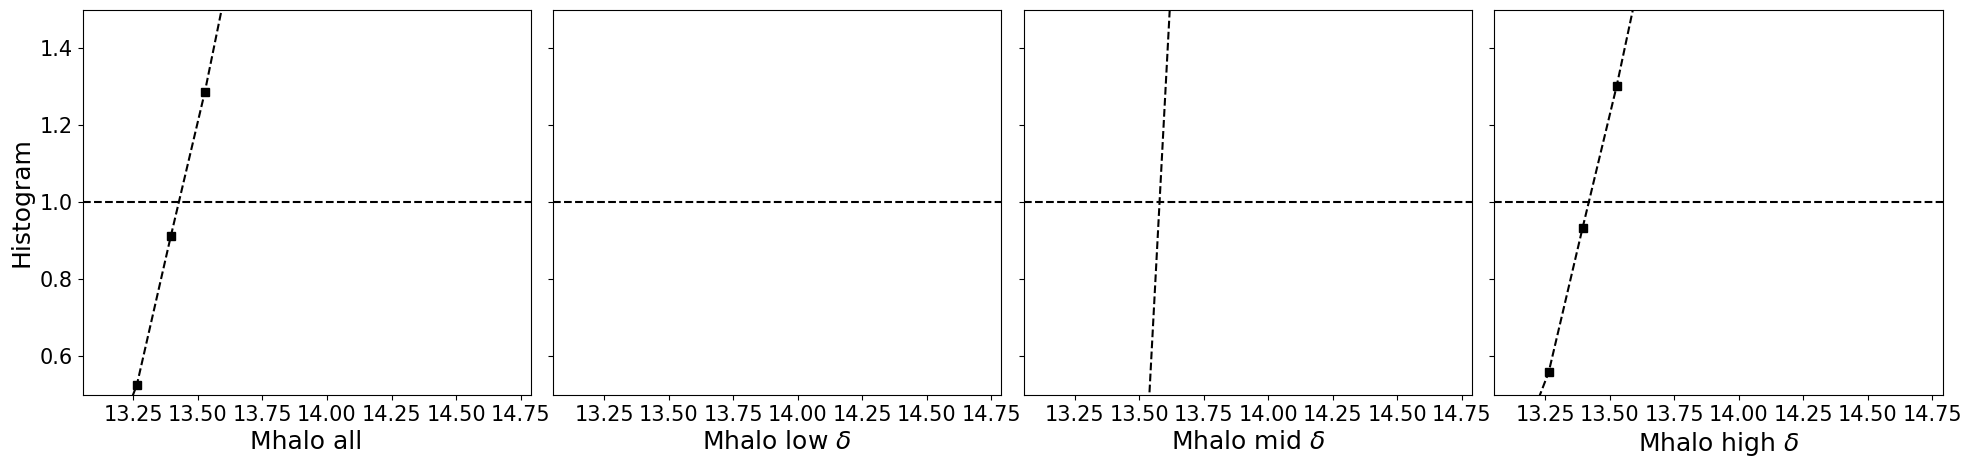

In [29]:
fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=True, sharex=True, gridspec_kw={'wspace': 0.05, 'hspace': 0})
jM = 1
for idim in range(4):
    # M_idim_truth = df_Mh_all_truth[..., idim]
    # hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
    if idim == 0:
        ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_all_Mhalo'][jM,:]/saved_all_jsim['hist_truth_all_Mhalo'][jM,:], marker='s', color='k', ls='--', label='Truth')    
        # ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_all_Mhalo'][jM,:], marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Mhalo all', size=18)

    if idim == 1:
        ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_low_Mhalo'][jM,:]/saved_all_jsim['hist_truth_low_Mhalo'][jM,:], marker='s', color='k', ls='--', label='Truth')    
        # ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_low_Mhalo'][jM,:], marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Mhalo low $\delta$', size=18)        

    if idim == 2:
        ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_mid_Mhalo'][jM,:]/saved_all_jsim['hist_truth_mid_Mhalo'][jM,:], marker='s', color='k', ls='--', label='Truth')    
        # ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_mid_Mhalo'][jM,:], marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Mhalo mid $\delta$', size=18)        

    if idim == 3:
        ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_high_Mhalo'][jM,:]/saved_all_jsim['hist_truth_high_Mhalo'][jM,:], marker='s', color='k', ls='--', label='Truth')    
        # ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_high_Mhalo'][jM,:], marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_xlabel(r'Mhalo high $\delta$', size=18)        

    # ax[idim].set_yscale('log')
    ax[idim].set_ylim(0.5, 1.5)
    ax[idim].axhline(1.0, ls='--', color='k')
    ax[idim].tick_params(axis='both', which='major', labelsize=15)
    ax[idim].tick_params(axis='both', which='minor', labelsize=15)
    
    if idim == 0:
        ax[idim].set_ylabel('Histogram', size=18)




        

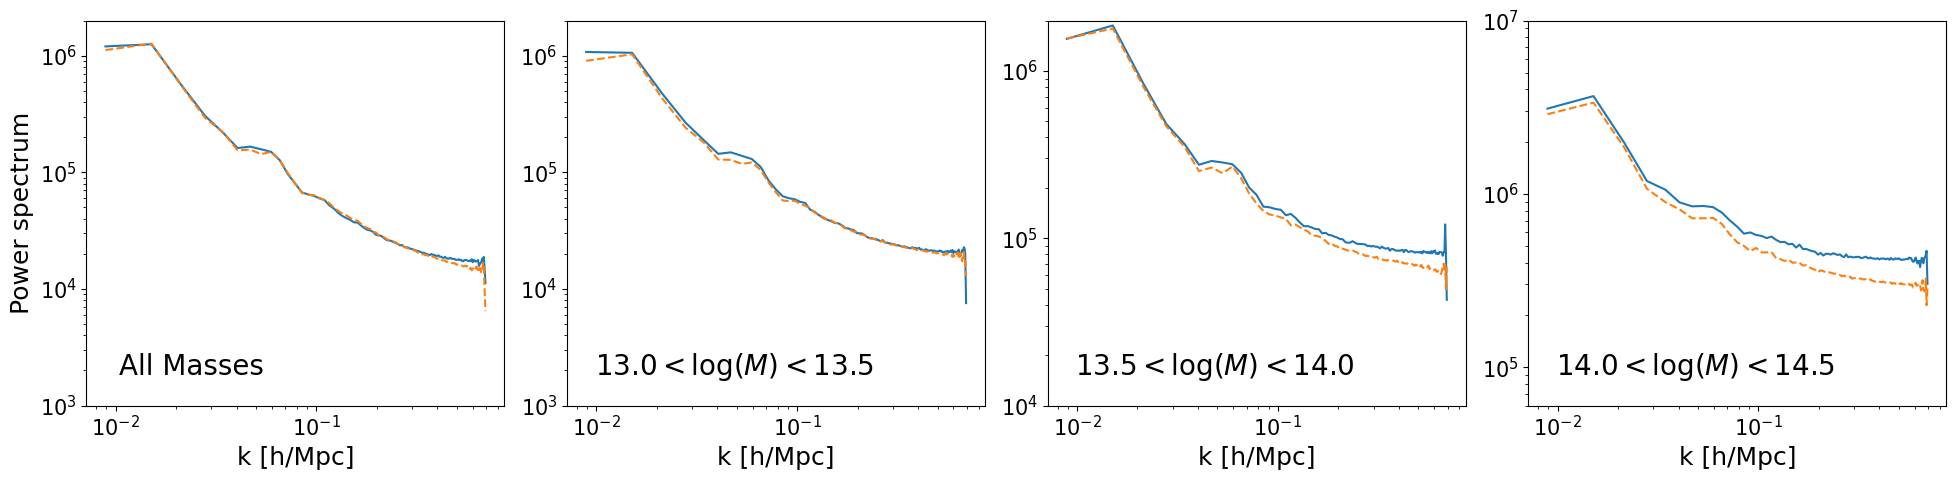

In [57]:
fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=False, sharex=True, gridspec_kw={'wspace': 0.15, 'hspace': 0})
for idim in range(4):
    # M_idim_truth = df_Mh_all_truth[..., idim]
    # hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
    if idim == 0:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_truth'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock'], ls='--')
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mockxtruth'], ls=':')
        ax[idim].text(0.25, 0.1, 'All Masses', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_ylim(1e3, 2e5)
        ax[idim].set_ylim(1e3, 2e6)
    
    if idim == 1:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_truth'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mock'], ls='--')
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mockxtruth'], ls=':')
        # ax[idim].text(0.25, 0.1, MAS_all[1][0] + '; ' + str(MAS_all[1][1]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_ylim(1e3, 2e5)
        ax[idim].set_ylim(1e3, 2e6)
    if idim == 2:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_truth'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mock'], ls='--')
        ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mockxtruth'], ls=':')
        # ax[idim].text(0.25, 0.1, MAS_all[2][0] + '; ' + str(MAS_all[2][1]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_ylim(1e4, 2e5)
        ax[idim].set_ylim(1e4, 2e6)
    if idim == 3:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_truth'])
        ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mock'], ls='--')
        ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mockxtruth'], ls=':')
        # ax[idim].text(0.25, 0.1, MAS_all[3][0] + '; ' + str(MAS_all[3][1]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_ylim(1e4, 1e6)
        ax[idim].set_ylim(6e4, 1e7)
    ax[idim].set_yscale('log')
    ax[idim].set_xscale('log')  
    # ax[idim].grid()  
    ax[idim].tick_params(axis='both', which='major', labelsize=15)
    ax[idim].tick_params(axis='both', which='minor', labelsize=15)
    ax[idim].set_xlabel('k [h/Mpc]', size=18)
    
    if idim == 0:
        ax[idim].set_ylabel('Power spectrum', size=18)

    # ax[idim].set_ylim(1e3, 1e5)


    

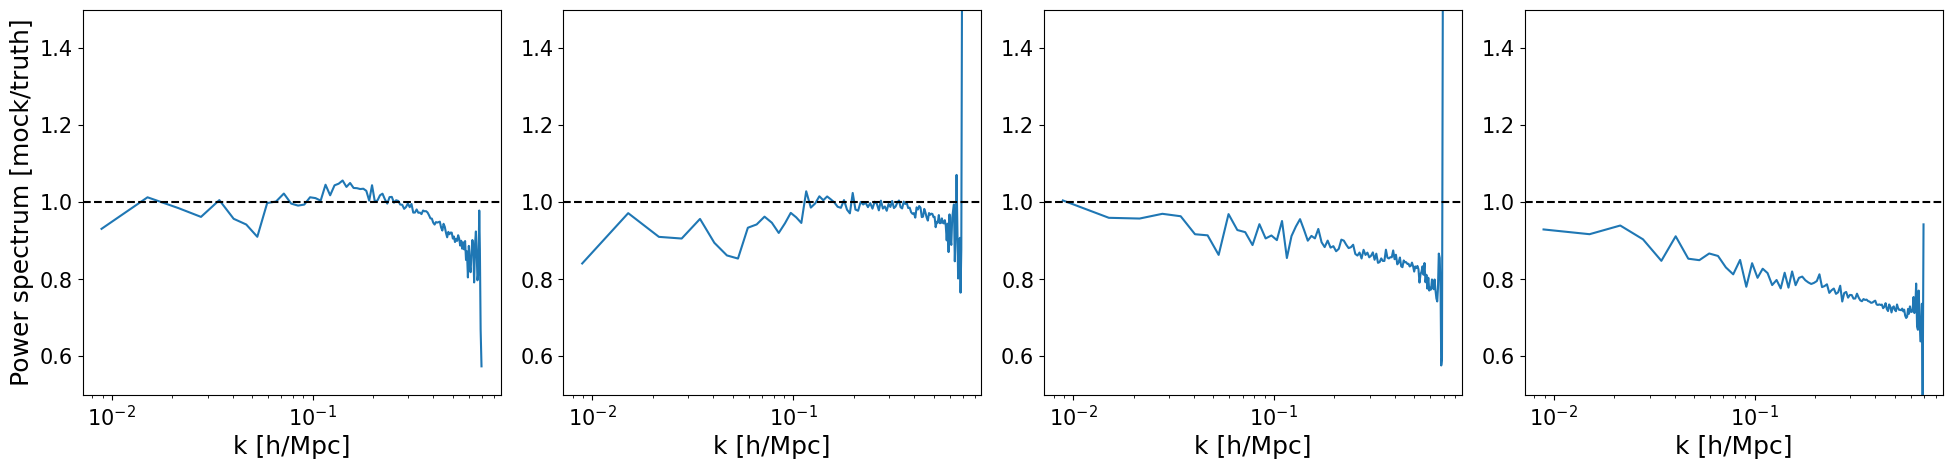

In [58]:
fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=False, sharex=True, gridspec_kw={'wspace': 0.15, 'hspace': 0})
for idim in range(4):
    # M_idim_truth = df_Mh_all_truth[..., idim]
    # hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
    if idim == 0:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock']/saved_all_jsim['Pk_Bk'][0]['Pk_truth'])
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock'], ls='--')
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mockxtruth'], ls=':')
        # ax[idim].text(0.25, 0.1, MAS_all[0][0] + '; ' + str(MAS_all[0][1]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_ylim(1e3, 1e5)
    if idim == 1:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mock']/saved_all_jsim['Pk_Bk'][1]['Pk_truth'])
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mock'], ls='--')
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mockxtruth'], ls=':')
        # ax[idim].text(0.25, 0.1, MAS_all[1][0] + '; ' + str(MAS_all[1][1]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_ylim(1e3, 1e5)
    if idim == 2:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mock']/saved_all_jsim['Pk_Bk'][2]['Pk_truth'])
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mock'], ls='--')
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mockxtruth'], ls=':')
        # ax[idim].text(0.25, 0.1, MAS_all[2][0] + '; ' + str(MAS_all[2][1]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_ylim(1e4, 1e6)
    if idim == 3:
        ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mock']/saved_all_jsim['Pk_Bk'][3]['Pk_truth'])
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mock'], ls='--')
        # ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mockxtruth'], ls=':')
        # ax[idim].text(0.25, 0.1, MAS_all[3][0] + '; ' + str(MAS_all[3][1]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_ylim(6e4, 6e6)
    # ax[idim].set_yscale('log')
    ax[idim].set_xscale('log')  
    # ax[idim].grid()  
    ax[idim].tick_params(axis='both', which='major', labelsize=15)
    ax[idim].tick_params(axis='both', which='minor', labelsize=15)
    ax[idim].set_xlabel('k [h/Mpc]', size=18)
    
    if idim == 0:
        ax[idim].set_ylabel('Power spectrum [mock/truth]', size=18)

    ax[idim].axhline(1.0, ls='--', color='k')
    ax[idim].set_ylim(0.5, 1.5)


    

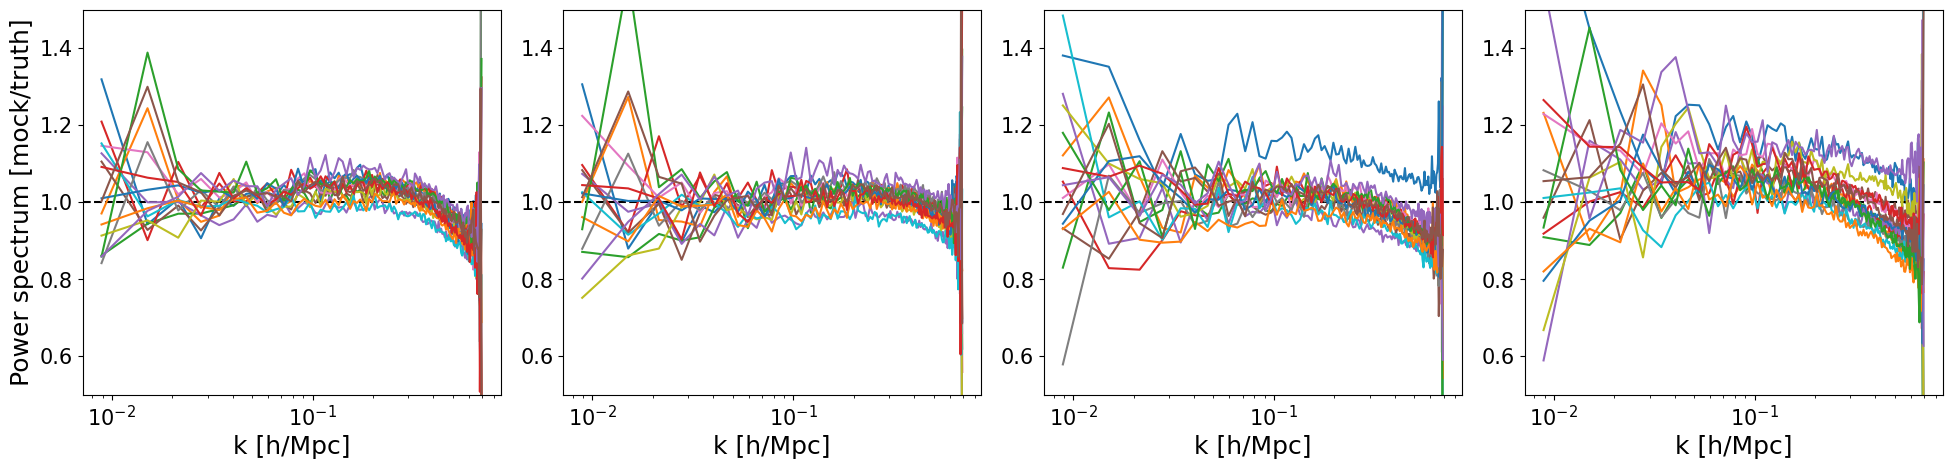

In [25]:
fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=False, sharex=True, gridspec_kw={'wspace': 0.15, 'hspace': 0})

for ji in range(len(saved_all_test)):
    saved_all_jsim = saved_all_test[ji]
    for idim in range(4):
        if idim == 0:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock']/saved_all_jsim['Pk_Bk'][0]['Pk_truth'])
        if idim == 1:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mock']/saved_all_jsim['Pk_Bk'][1]['Pk_truth'])
        if idim == 2:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mock']/saved_all_jsim['Pk_Bk'][2]['Pk_truth'])
        if idim == 3:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mock']/saved_all_jsim['Pk_Bk'][3]['Pk_truth'])
        # ax[idim].set_yscale('log')
        if ji == 0:
            # ax[idim].set_xscale('log')
            ax[idim].set_xscale('log')  
            # ax[idim].grid()  
            ax[idim].tick_params(axis='both', which='major', labelsize=15)
            ax[idim].tick_params(axis='both', which='minor', labelsize=15)
            ax[idim].set_xlabel('k [h/Mpc]', size=18)
            
            if idim == 0:
                ax[idim].set_ylabel('Power spectrum [mock/truth]', size=18)

            ax[idim].axhline(1.0, ls='--', color='k')
            ax[idim].set_ylim(0.5, 1.5)


    

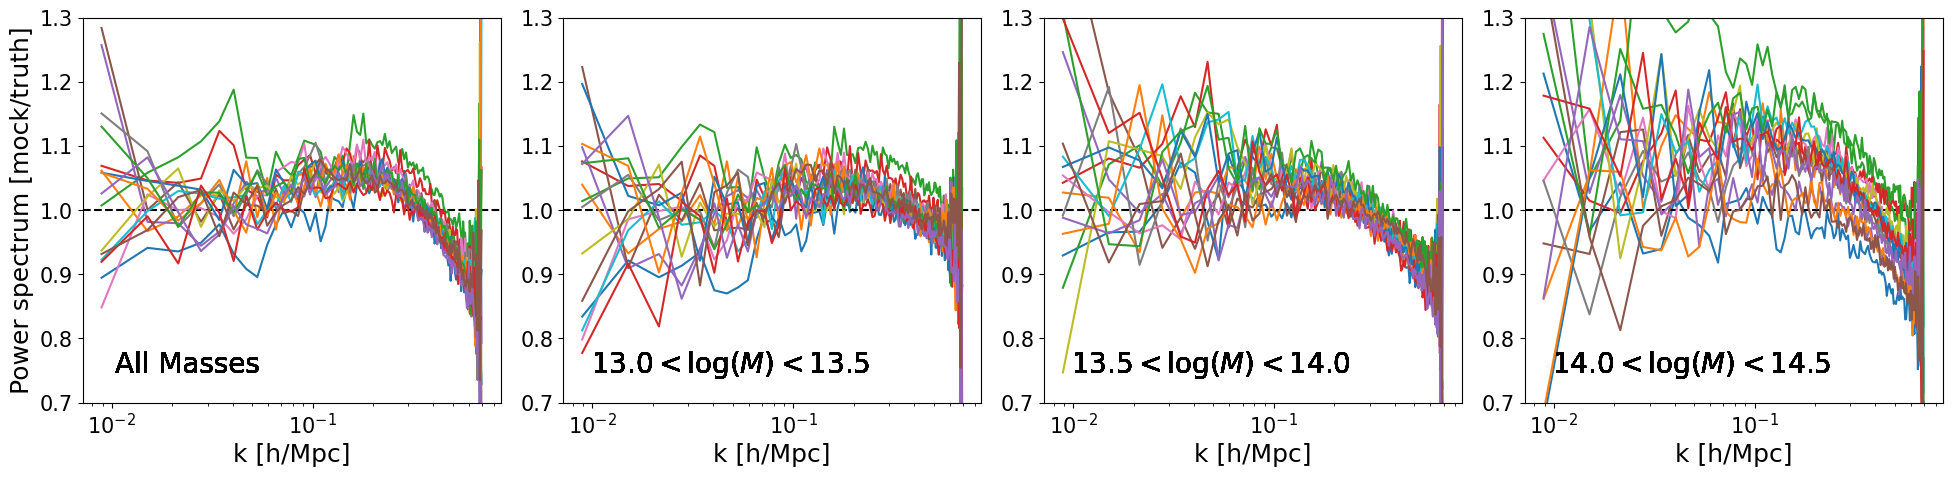

In [26]:
fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=False, sharex=True, gridspec_kw={'wspace': 0.15, 'hspace': 0})

for ji in range(len(saved_all_test)):
    saved_all_jsim = saved_all_test[ji]
    for idim in range(4):
        if idim == 0:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock']/saved_all_jsim['Pk_Bk'][0]['Pk_truth'])
            ax[idim].text(0.25, 0.1, 'All Masses', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        if idim == 1:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mock']/saved_all_jsim['Pk_Bk'][1]['Pk_truth'])
            ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        if idim == 2:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mock']/saved_all_jsim['Pk_Bk'][2]['Pk_truth'])
            ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        if idim == 3:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mock']/saved_all_jsim['Pk_Bk'][3]['Pk_truth'])
            ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_yscale('log')
        if ji == 0:
            # ax[idim].set_xscale('log')
            ax[idim].set_xscale('log')  
            # ax[idim].grid()  
            ax[idim].tick_params(axis='both', which='major', labelsize=15)
            ax[idim].tick_params(axis='both', which='minor', labelsize=15)
            ax[idim].set_xlabel('k [h/Mpc]', size=18)
            
            if idim == 0:
                ax[idim].set_ylabel('Power spectrum [mock/truth]', size=18)

            ax[idim].axhline(1.0, ls='--', color='k')
            ax[idim].set_ylim(0.7, 1.3)


    

/tmp/ipykernel_2422473/2349065103.py:23: RuntimeWarning: divide by zero encountered in divide
  ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_low_Nhalo']/saved_all_jsim['hist_truth_low_Nhalo'], marker='s', color=color_ji,  ls='-', lw=2,  label='Truth', alpha=alpha_plot)
/tmp/ipykernel_2422473/2349065103.py:23: RuntimeWarning: invalid value encountered in divide
  ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_low_Nhalo']/saved_all_jsim['hist_truth_low_Nhalo'], marker='s', color=color_ji,  ls='-', lw=2,  label='Truth', alpha=alpha_plot)
/tmp/ipykernel_2422473/2349065103.py:28: RuntimeWarning: divide by zero encountered in divide
  ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_mid_Nhalo']/saved_all_jsim['hist_truth_mid_Nhalo'], marker='s', color=color_ji,  ls='-', lw=2,  label='Truth', alpha=alpha_plot)
/tmp/ipykernel_2422473/2349065103.py:28: RuntimeWarning: invalid value encountered in divide
  ax[idi

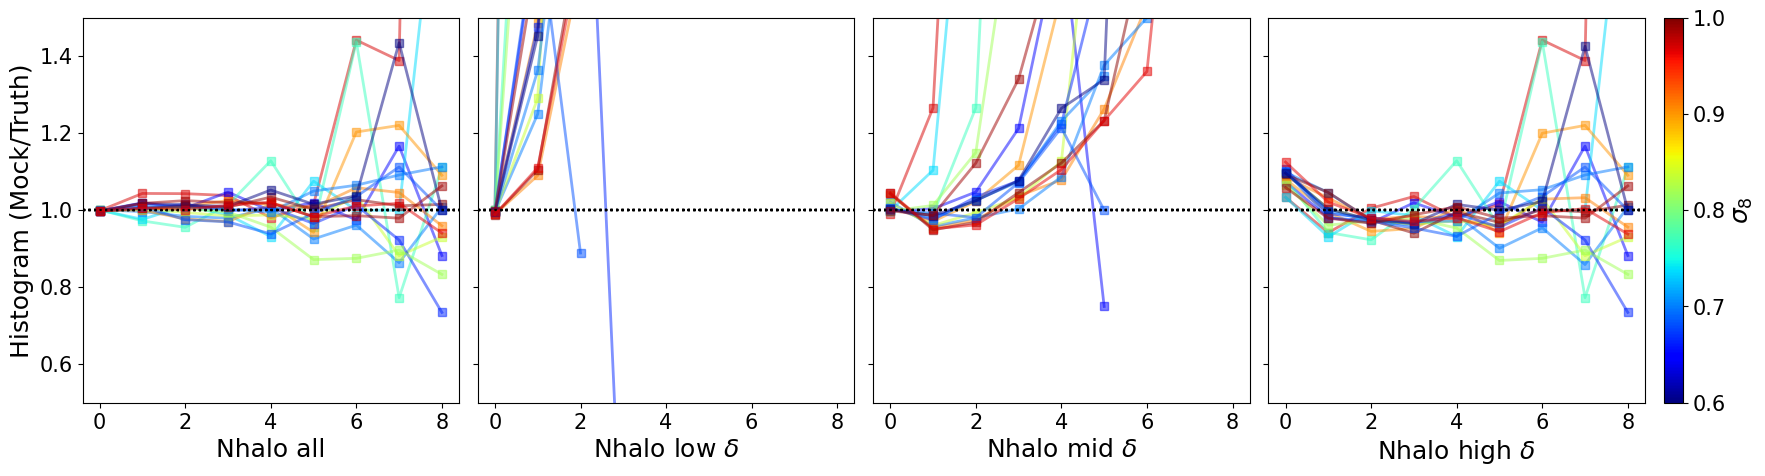

In [33]:
from matplotlib import cm

#normalize item number values to colormap
norm = matplotlib.colors.Normalize(vmin=0.6, vmax=1.0)

alpha_plot = 0.5
fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=True, sharex=True, gridspec_kw={'wspace': 0.05, 'hspace': 0})
for ji in range(len(saved_all_test)):
    saved_all_jsim = saved_all_test[ji]
    cosmo_ji = saved_all_jsim['cosmology']
    sigma8_ji = cosmo_ji[-1]
    color_ji = cm.jet(norm(sigma8_ji)) 

    for idim in range(4):
        # M_idim_truth = df_Mh_all_truth[..., idim]
        # hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
        if idim == 0:
            ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_all_Nhalo']/saved_all_jsim['hist_truth_all_Nhalo'], marker='s', color=color_ji, ls='-', lw=2, label='Truth', alpha=alpha_plot)    
            # ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], , marker='o', color='b', ls='-', label='Sampled')
            ax[idim].set_xlabel(r'Nhalo all', size=18)

        if idim == 1:
            ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_low_Nhalo']/saved_all_jsim['hist_truth_low_Nhalo'], marker='s', color=color_ji,  ls='-', lw=2,  label='Truth', alpha=alpha_plot)
            # ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], , marker='o', color='b', ls='-', label='Sampled')
            ax[idim].set_xlabel(r'Nhalo low $\delta$', size=18)        

        if idim == 2:
            ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_mid_Nhalo']/saved_all_jsim['hist_truth_mid_Nhalo'], marker='s', color=color_ji,  ls='-', lw=2,  label='Truth', alpha=alpha_plot)
            # ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], , marker='o', color='b', ls='-', label='Sampled')
            ax[idim].set_xlabel(r'Nhalo mid $\delta$', size=18)        

        if idim == 3:
            ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_high_Nhalo']/saved_all_jsim['hist_truth_high_Nhalo'], marker='s', color=color_ji,  ls='-', lw=2,  label='Truth', alpha=alpha_plot)
            # ax[idim].plot(saved_all_jsim['Nhalo_bin_cents'], , marker='o', color='b', ls='-', label='Sampled')
            ax[idim].set_xlabel(r'Nhalo high $\delta$', size=18)        

        ax[idim].axhline(1.0, ls=':', color='k')
        ax[idim].tick_params(axis='both', which='major', labelsize=15)
        ax[idim].tick_params(axis='both', which='minor', labelsize=15)
        ax[idim].set_ylim(0.5, 1.5)
        ax[idim].grid()
        if idim == 0:
            ax[idim].set_ylabel('Histogram (Mock/Truth)', size=18)
    if ji == 0:
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=ax, label=r'$\sigma_8$', pad=0.01)
        # set labelsize and colorbar location:
        # cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label(r'$\sigma_8$', size=18)
        cbar.set_ticks(np.arange(0.6, 1.01, 0.1))
            


/tmp/ipykernel_2422473/3946104850.py:21: RuntimeWarning: divide by zero encountered in divide
  ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_low_Mhalo'][jM,:]/saved_all_jsim['hist_truth_low_Mhalo'][jM,:], color=color_ji, marker='s',  ls='-', label='Truth', alpha=alpha_plot)
/tmp/ipykernel_2422473/3946104850.py:21: RuntimeWarning: invalid value encountered in divide
  ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_low_Mhalo'][jM,:]/saved_all_jsim['hist_truth_low_Mhalo'][jM,:], color=color_ji, marker='s',  ls='-', label='Truth', alpha=alpha_plot)
/tmp/ipykernel_2422473/3946104850.py:26: RuntimeWarning: divide by zero encountered in divide
  ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_mid_Mhalo'][jM,:]/saved_all_jsim['hist_truth_mid_Mhalo'][jM,:], color=color_ji, marker='s',  ls='-', label='Truth', alpha=alpha_plot)
/tmp/ipykernel_2422473/3946104850.py:26: RuntimeWarning: invalid value encountered in 

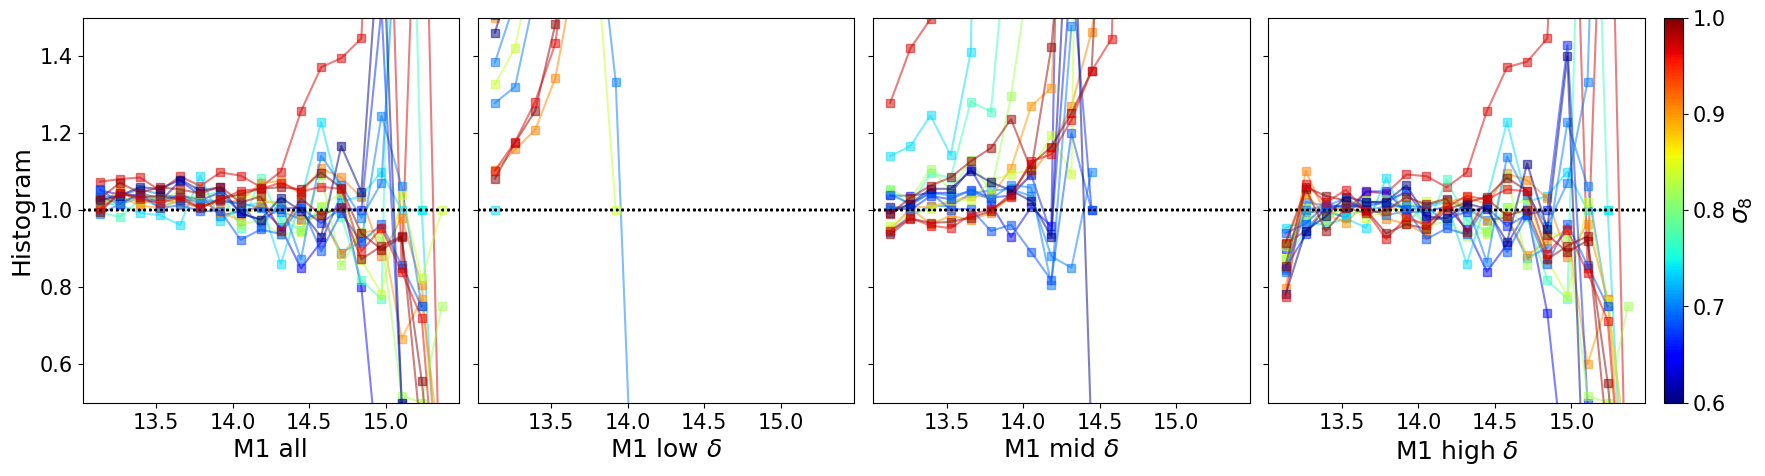

In [48]:
norm = matplotlib.colors.Normalize(vmin=0.6, vmax=1.0)

alpha_plot = 0.5

fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=True, sharex=True, gridspec_kw={'wspace': 0.05, 'hspace': 0})
jM = 0
for ji in range(len(saved_all_test)):
    saved_all_jsim = saved_all_test[ji]
    cosmo_ji = saved_all_jsim['cosmology']
    sigma8_ji = cosmo_ji[-1]
    color_ji = cm.jet(norm(sigma8_ji)) 
    for idim in range(4):
        # M_idim_truth = df_Mh_all_truth[..., idim]
        # hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
        if idim == 0:
            ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_all_Mhalo'][jM,:]/saved_all_jsim['hist_truth_all_Mhalo'][jM,:], color=color_ji, marker='s',  ls='-', label='Truth', alpha=alpha_plot)    
            # ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_all_Mhalo'][jM,:], marker='o', color='b', ls='-', label='Sampled')
            ax[idim].set_xlabel(r'M1 all', size=18)

        if idim == 1:
            ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_low_Mhalo'][jM,:]/saved_all_jsim['hist_truth_low_Mhalo'][jM,:], color=color_ji, marker='s',  ls='-', label='Truth', alpha=alpha_plot)    
            # ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_low_Mhalo'][jM,:], marker='o', color='b', ls='-', label='Sampled')
            ax[idim].set_xlabel(r'M1 low $\delta$', size=18)        

        if idim == 2:
            ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_mid_Mhalo'][jM,:]/saved_all_jsim['hist_truth_mid_Mhalo'][jM,:], color=color_ji, marker='s',  ls='-', label='Truth', alpha=alpha_plot)    
            # ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_mid_Mhalo'][jM,:], marker='o', color='b', ls='-', label='Sampled')
            ax[idim].set_xlabel(r'M1 mid $\delta$', size=18)        

        if idim == 3:
            ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_high_Mhalo'][jM,:]/saved_all_jsim['hist_truth_high_Mhalo'][jM,:], color=color_ji, marker='s', ls='-', label='Truth', alpha=alpha_plot)    
            # ax[idim].plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_high_Mhalo'][jM,:], marker='o', color='b', ls='-', label='Sampled')
            ax[idim].set_xlabel(r'M1 high $\delta$', size=18)        

        # ax[idim].set_yscale('log')
        ax[idim].tick_params(axis='both', which='major', labelsize=15)
        ax[idim].tick_params(axis='both', which='minor', labelsize=15)
        ax[idim].set_ylim(0.5, 1.5)
        ax[idim].axhline(1.0, ls=':', color='k')
        if idim == 0:
            ax[idim].set_ylabel('Histogram', size=18)


    if ji == 0:
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=ax, label=r'$\sigma_8$', pad=0.01)
        # set labelsize and colorbar location:
        # cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label(r'$\sigma_8$', size=18)
        cbar.set_ticks(np.arange(0.6, 1.01, 0.1))
            


            

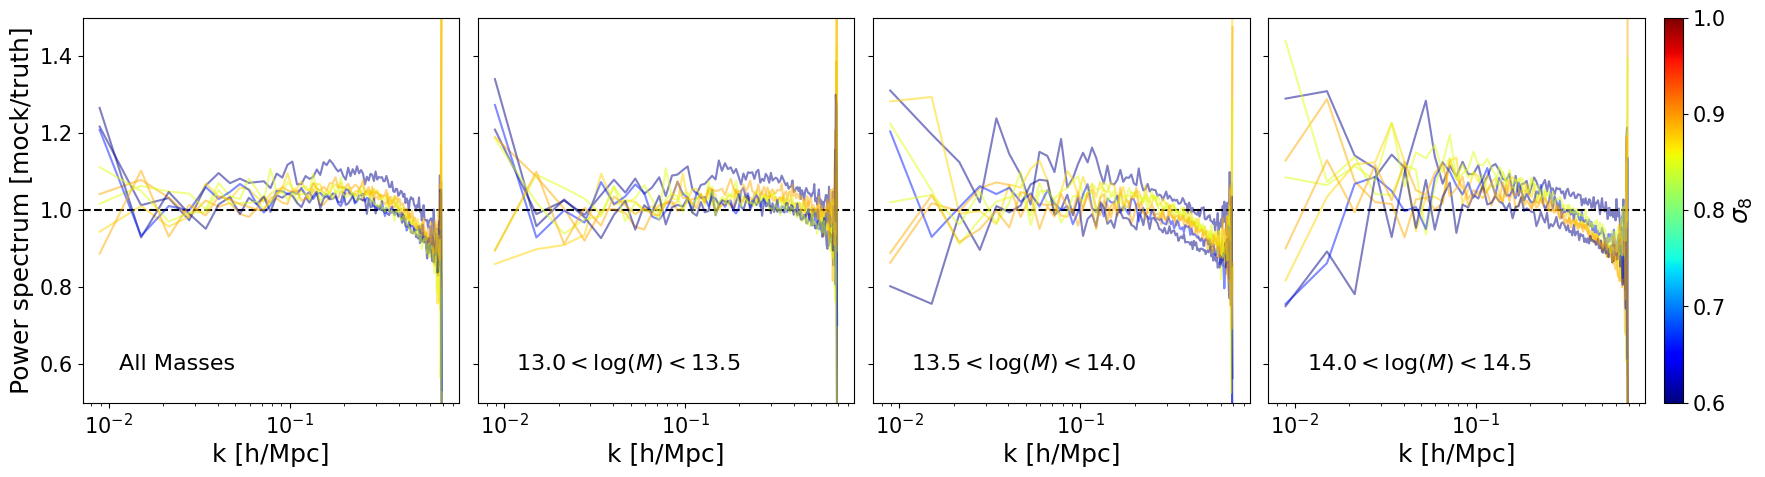

In [25]:
from matplotlib import cm
norm = matplotlib.colors.Normalize(vmin=0.6, vmax=1.0)

alpha_plot = 0.5

fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=True, sharex=True, gridspec_kw={'wspace': 0.05, 'hspace': 0})

for ji in range(len(saved_all_test)):
    saved_all_jsim = saved_all_test[ji]
    cosmo_ji = saved_all_jsim['cosmology']
    sigma8_ji = cosmo_ji[-1]
    color_ji = cm.jet(norm(sigma8_ji)) 

    for idim in range(4):
        if idim == 0:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock']/saved_all_jsim['Pk_Bk'][0]['Pk_truth'], color=color_ji, alpha=alpha_plot)    
            if ji == 0:
                ax[idim].text(0.25, 0.1, 'All Masses', fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        if idim == 1:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mock']/saved_all_jsim['Pk_Bk'][1]['Pk_truth'], color=color_ji, alpha=alpha_plot)    
            if ji == 0:            
                ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        if idim == 2:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mock']/saved_all_jsim['Pk_Bk'][2]['Pk_truth'], color=color_ji, alpha=alpha_plot)    
            if ji == 0:            
                ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        if idim == 3:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mock']/saved_all_jsim['Pk_Bk'][3]['Pk_truth'], color=color_ji, alpha=alpha_plot)    
            if ji == 0:            
                ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_yscale('log')
        if ji == 0:
            # ax[idim].set_xscale('log')
            ax[idim].set_xscale('log')  
            # ax[idim].grid()  
            ax[idim].tick_params(axis='both', which='major', labelsize=15)
            ax[idim].tick_params(axis='both', which='minor', labelsize=15)
            ax[idim].set_xlabel('k [h/Mpc]', size=18)
            
            if idim == 0:
                ax[idim].set_ylabel('Power spectrum [mock/truth]', size=18)

            ax[idim].axhline(1.0, ls='--', color='k')
            ax[idim].set_ylim(0.5, 1.5)

    if ji == 0:
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=ax, label=r'$\sigma_8$', pad=0.01)
        # set labelsize and colorbar location:
        # cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label(r'$\sigma_8$', size=18)
        cbar.set_ticks(np.arange(0.6, 1.01, 0.1))
            

    

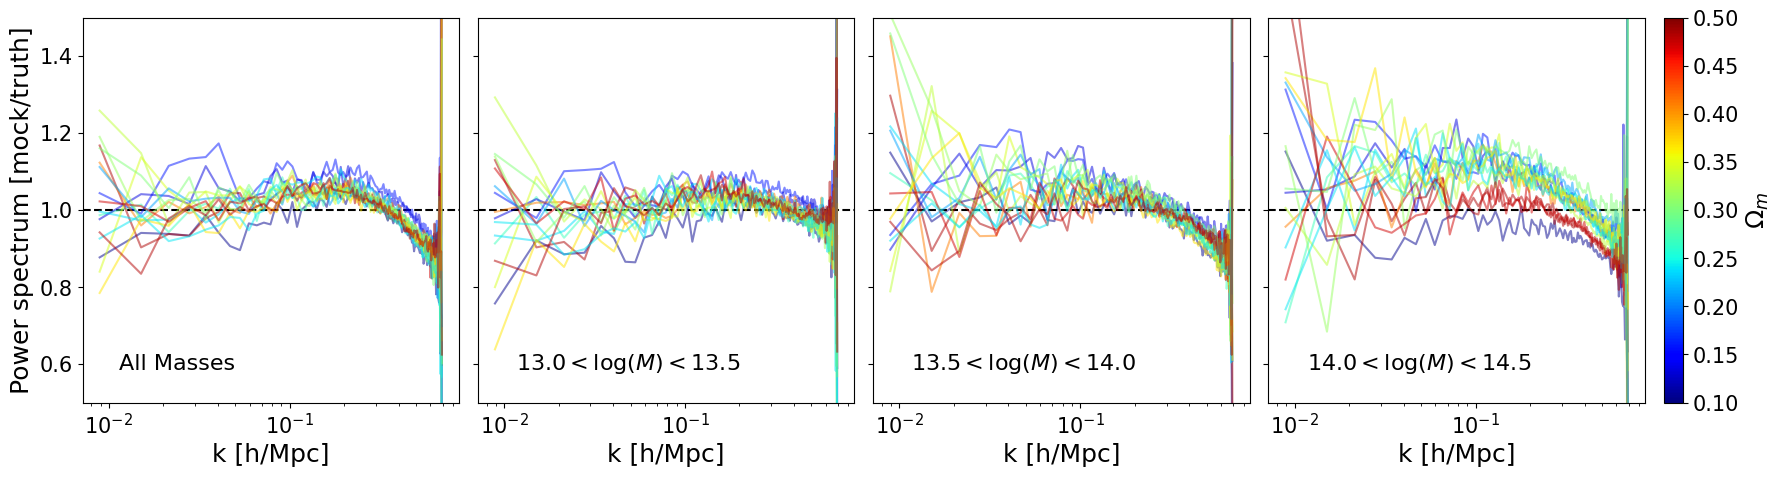

In [51]:

norm = matplotlib.colors.Normalize(vmin=0.1, vmax=0.5)

alpha_plot = 0.5

fig, ax = pl.subplots(1,4, figsize=(24,5), sharey=True, sharex=True, gridspec_kw={'wspace': 0.05, 'hspace': 0})

for ji in range(len(saved_all_test)):
    saved_all_jsim = saved_all_test[ji]
    cosmo_ji = saved_all_jsim['cosmology']
    # sigma8_ji = cosmo_ji[-1]
    # color_ji = cm.jet(norm(sigma8_ji)) 
    Om_ji = cosmo_ji[0]
    color_ji = cm.jet(norm(Om_ji)) 



    for idim in range(4):
        if idim == 0:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock']/saved_all_jsim['Pk_Bk'][0]['Pk_truth'], color=color_ji, alpha=alpha_plot)    
            if ji == 0:
                ax[idim].text(0.25, 0.1, 'All Masses', fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        if idim == 1:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][1]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_mock']/saved_all_jsim['Pk_Bk'][1]['Pk_truth'], color=color_ji, alpha=alpha_plot)    
            if ji == 0:            
                ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        if idim == 2:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][2]['k_Pk'], saved_all_jsim['Pk_Bk'][2]['Pk_mock']/saved_all_jsim['Pk_Bk'][2]['Pk_truth'], color=color_ji, alpha=alpha_plot)    
            if ji == 0:            
                ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        if idim == 3:
            ax[idim].plot(saved_all_jsim['Pk_Bk'][3]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_mock']/saved_all_jsim['Pk_Bk'][3]['Pk_truth'], color=color_ji, alpha=alpha_plot)    
            if ji == 0:            
                ax[idim].text(0.4, 0.1, str(Mmin_Pk_all[idim]) + r'$< \log(M) < $' + str(Mmax_Pk_all[idim]), fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax[idim].transAxes)
        # ax[idim].set_yscale('log')
        if ji == 0:
            # ax[idim].set_xscale('log')
            ax[idim].set_xscale('log')  
            # ax[idim].grid()  
            ax[idim].tick_params(axis='both', which='major', labelsize=15)
            ax[idim].tick_params(axis='both', which='minor', labelsize=15)
            ax[idim].set_xlabel('k [h/Mpc]', size=18)
            
            if idim == 0:
                ax[idim].set_ylabel('Power spectrum [mock/truth]', size=18)

            ax[idim].axhline(1.0, ls='--', color='k')
            ax[idim].set_ylim(0.5, 1.5)

    if ji == 0:
        # cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=ax, label=r'$\sigma_8$', pad=0.01)
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=ax, label=r'$\Omega_m$', pad=0.01)        
        # set labelsize and colorbar location:
        # cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label(r'$\Omega_m$', size=18)
        # cbar.set_ticks(np.arange(0.6, 1.01, 0.1))
            

    